# SXSW Sentiment Analysis via Twitter
## Apple Brand and Products

Data Source: [Crowdflower](https://data.world/crowdflower/brands-and-product-emotions)

## Business Understanding

The goal of this project is to present the director of marketing at Apple with information about sentiment toward the Apple brand and Apple products in the "tech world" as approximated by a collection of tweets from the South by Southwest Conference. A secondary goal is to test the feasibility of monitoring brand sentiment in tweets concerning Apple using a machine learning model trained on human-labeled tweets.

## Data Understanding

We have a collection of ~9,000 tweets from SXSW (a conglomeration of tech conference, concerts and exhibits in other areas) concerning Apple, Android and Google products with the sentiment labeled as ("positive", "negative", "neutral", or "I can't tell".) Some tweets also have the object of the sentiment in the tweet labeled.

## Imports

All packages used in this notebook are imported in the cell below. A brief description of what each import is used for is provided.

In [49]:
# set a random seed for reproducibility
seed = 3490

# data manipulation and visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from matplotlib.container import BarContainer

# train test split
from sklearn.model_selection import train_test_split

# label encode target
from sklearn.preprocessing import LabelEncoder

# natural language processing tools
import string
from nltk.corpus import stopwords

from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer

from nltk.corpus import wordnet
import nltk

from nltk import FreqDist

# vectorize text
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# decompose feature space
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import PCA

# scale features
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# classifiers
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC

# grid search for tuning hyperparameters
from sklearn.model_selection import GridSearchCV

# confusion matrix to analyze model performance
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# use gensim to download GloVe embeddings
import gensim.downloader

# use gensim to generate Word2Vec embeddings for our dataset
from gensim.models import Word2Vec

## Load Data

The data is a static csv file which has been downloaded from Crowdflower (see top of notebook for link to data source) and stored in the local version of this repository.

In [3]:
# load data from file; encoding is "latin1"
data = pd.read_csv('data/judge-1377884607_tweet_product_company.csv', encoding='latin1')

# inspect first few rows
data.head()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


In [3]:
data.shape

(9093, 3)

How many tweets contain #SXSW, #sxsw, sxsw, SXSW, or some variation thereof? (Answer: about 32%.)

In [10]:
data_list = data.dropna().copy()
data_list['tweet_words'] = data_list.tweet_text.map(lambda x: [w.lower() for w in x.split()])
exploded = data_list.reset_index().rename({'index': 'true_index'}, axis=1).explode('tweet_words')
about_sxsw = exploded.loc[(exploded.tweet_words == '#sxsw') | (exploded.tweet_words=='sxsw')].true_index.values

In [12]:
len(about_sxsw) / data.shape[0]

0.3202463433410316

Here are a few examples:

In [14]:
for tweet in data.tweet_text.loc[about_sxsw].sample(5, random_state=seed):
    print(tweet)

Dan Neumann just announced the launch of Organic's first consumer-facing iPad app, Broadfeed at #SXSW 
check it out!!
#LonelyPlanet #Austin iPhone app is a (free!) godsend. GPS-aware map of the city without the need for 3G or WiFi! #sxsw
Line for the iPad 2, at the Apple Store. No demo units until 5pm. #sxsw #fb {link} {link}
sweet new 3-d google maps demo going on in ballroom D #SXSW
Even security guards in Austin enjoy iPad time. #SXSW (cc @mention {link}


## Explore Data

The column names are a mouthful ("is_there_an_emotion_directed_at_a_brand_or_product"), so let's rename them for ease.

In [15]:
# rename last two columns, in place
data.rename({'emotion_in_tweet_is_directed_at': 'object_of_sentiment',
             'is_there_an_emotion_directed_at_a_brand_or_product': 'sentiment'}, axis=1, inplace=True)
# inspect first few rows
data.head()

,tweet_text,object_of_sentiment,sentiment
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


Now let's explore the distribution of the data.

In [16]:
data.sentiment.value_counts()

sentiment
No emotion toward brand or product    5389
Positive emotion                      2978
Negative emotion                       570
I can't tell                           156
Name: count, dtype: int64

Sample a few tweets which have unlabeled sentiment.

In [17]:
for i in data.loc[data.sentiment=="I can't tell"].sample(5, random_state=seed).index:
    print(data.loc[i, 'tweet_text'])

Finally got my #SXSW schedule on my #google calendar. #coudbeeasier
funny! iphone correction? RT @mention Dashing off to learn a thing or two about longhorn journalism #SXSW
&quot;Do you know what Apple is really good at? Making you feel bad about your Xmas present!&quot; - Seth Meyers on iPad2 #sxsw #doyoureallyneedthat?
+1 ÛÏ@mention +1 RT @mention Petricone says Google TV is just a browser. I don't think that's correct. #SXSWÛ
RT @mention Gary Vaynerchuck lÌ_gger ner winelibrary.tv och slÌ_pper i stÌ_llet Iphone-appen Daily Grape. #thankyoueconomy #sxsw #swesxsw


I will drop these records.

In [18]:
# replace "I can't tell" in sentiment column with null
data.sentiment = data.sentiment.replace({"I can't tell": None})

In [19]:
# drop records with null value for sentiment
data.dropna(subset='sentiment', inplace=True)

Now let's explore the distribution of products discussed in these tweets.

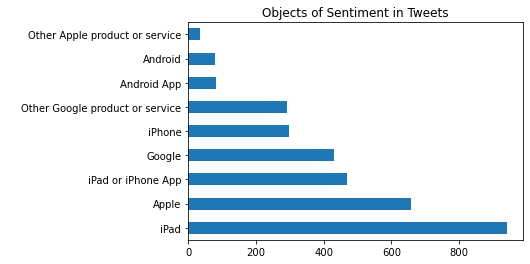

In [20]:
fig, ax = plt.subplots()

ax.set_title('Objects of Sentiment in Tweets')

data.object_of_sentiment.value_counts().plot(kind='barh')

ax.set_ylabel(' ');

# plt.savefig('data/graphs/objects_of_sentiment.jpg', bbox_inches='tight');

We have the most data on Apple products, and a little sprinkling of data on Google and Android products.

What is the sentiment breakdown by object?

Before we answer this question, first note that more than half of records do not have an object of sentiment.

In [21]:
data.object_of_sentiment.isna().sum()

5655

Check how many of these null sentiment records correspond to tweets which are neutral.

In [37]:
data.loc[(data.sentiment=='No emotion toward brand or product'), 'object_of_sentiment'].isna().sum()

5298

There are 5298 records for which sentiment is neutral, and the "object_of_sentiment" value is null.

This means that there are ~300 (5655 - 5298) records for which no object of sentiment is given, despite a positive or negative sentiment being recorded.

Let's view an example of such a tweet.

In [38]:
for i in data.loc[((data.sentiment=='Positive emotion') | (data.sentiment=='Negative emotion')) &
                  (data.object_of_sentiment.isna())].sample(3, random_state=seed).index:
    print(data.loc[i, 'tweet_text'])

My iPhone says it can't connect to the Internet even though #sxsw wifi works great on my computer. Any suggestions?
RT @mention The Web DesignerÛªs Guide to iOS (and Android) Apps, today @mention 10 a.m! {link} #sxsw
Imagine if every company had the 20% concept like Google. #bavcID #SXSW


One approach to deal with these null objects of sentiment is to classify them using the labeled data as training data (semi-supervised learning.) We may mis-classify some tweets, but hopefully we can capture the fact that some of these *are* clearly directed at specific products.

However, I'm not planning to build a classifier to identify the object of the sentiment in the first iteration of this project, so we can ignore these missing values for now.

Check the distribution of positive, negative and neutral tweets by product.

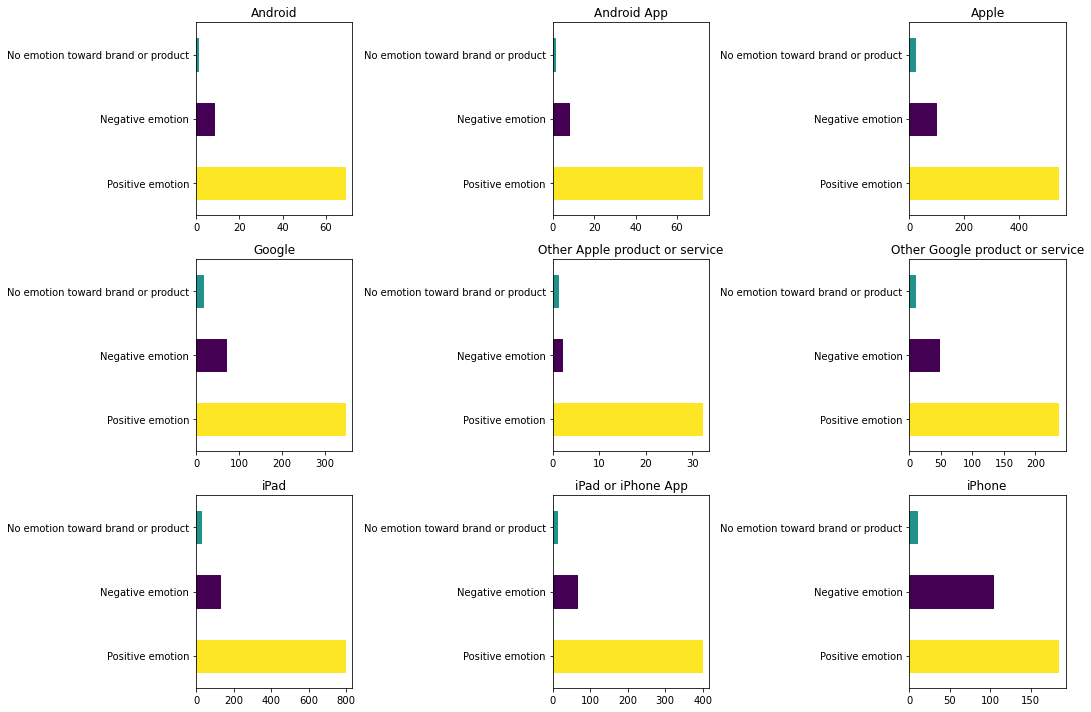

In [24]:
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(15, 10))

# set up color map for negative, positive and neutral tweets
viridis = mpl.colormaps['viridis'].resampled(3)

for n, product in enumerate(np.unique(data.object_of_sentiment.to_list())[:-1]):
    # get sentiment counts for this product
    df = data.loc[data.object_of_sentiment==product, 'sentiment'].value_counts().to_frame().reset_index()

    # plot bar chart
    df.plot(kind='barh', ax=ax[n//3][n%3])
    
    # set colors for each bar according to whether it is the count of positive, negative or neutral tweets
    bars = [i for i in ax[n//3][n%3].containers if isinstance(i, BarContainer)]
    colors = df.sentiment.replace({'Positive emotion': 2,
                                   'Negative emotion': 0,
                                   'No emotion toward brand or product': 1})
    for i in range(3):
        bars[0][i].set_color(viridis(colors[i]/2))
    
    # fix labels, remove legend
    ax[n//3][n%3].set_yticklabels(df['sentiment'])
    ax[n//3][n%3].get_legend().remove()
    
    # set title
    ax[n//3][n%3].set_title(f'{product}')
    
fig.tight_layout();

The iPhone has the highest ratio of negative to positive emotion tweets.

All brands have more positive mentions than negative, and relatively few neutral mentions.

Looking at the scale of the *x*-axes, we have the most mentions for Apple overall, then Google, then Android (with Android garnering much less attention.)

In [25]:
data.head(2)

,tweet_text,object_of_sentiment,sentiment
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion


----

Because a large proportion of tweets are neutral, and a large proportion of neutral tweets do not have an "object of sentiment" specified, we can only analyze sentiment toward the Apple brand and products, and Apple's competitors, using a subset of the larger dataset.

I'll group tweets in this subset by brand, and summarize brand sentiment using this information.

Get a copy of the dataset.

In [39]:
df = data.copy()

Add a column to the data called "Brand" which groups tweets by object of sentiment into brand categories (Apple, Google or Android.)

In [40]:
df.object_of_sentiment.value_counts()

object_of_sentiment
iPad                               942
Apple                              659
iPad or iPhone App                 470
Google                             429
iPhone                             296
Other Google product or service    292
Android App                         81
Android                             78
Other Apple product or service      35
Name: count, dtype: int64

In [42]:
apple_string = 'Apple products or brand'
google_string = 'Google products or brand'
android_string = 'Android products or brand'

df['brand'] =\
df.object_of_sentiment.replace({'iPhone': apple_string, 'iPad or iPhone App': apple_string, 'iPad': apple_string,
                                'Apple': apple_string, 'Google': google_string, 'Other Google product or service':
                                google_string, 'Android App': android_string, 'Android': android_string,
                                'Other Apple product or service': apple_string})

df.head()

,tweet_text,object_of_sentiment,sentiment,brand
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion,Apple products or brand
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion,Apple products or brand
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion,Apple products or brand
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion,Apple products or brand
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion,Google products or brand


In [43]:
df['brand'].value_counts()

brand
Apple products or brand      2402
Google products or brand      721
Android products or brand     159
Name: count, dtype: int64

In [44]:
df.head()

,tweet_text,object_of_sentiment,sentiment,brand
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion,Apple products or brand
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion,Apple products or brand
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion,Apple products or brand
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion,Apple products or brand
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion,Google products or brand


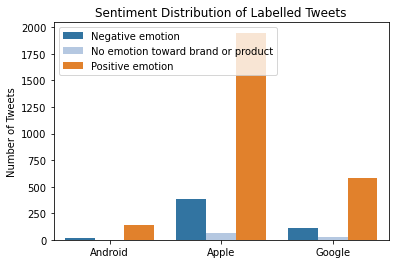

In [45]:
grouped_df = df.groupby(['brand', 'sentiment'], as_index=False).count().rename({'tweet_text': 'count'}, axis=1)

sns.barplot(data=grouped_df, x='brand', y='count', hue='sentiment', palette='tab20')

ax = plt.gca()
ax.set_title('Sentiment Distribution of Labelled Tweets')
ax.set_ylabel('Number of Tweets')
ax.set_xlabel(' ')
ax.set_xticklabels(['Android', 'Apple', 'Google'])
ax.legend(loc='upper left');

# plt.savefig('data/graphs/sentiment_by_brand.jpg', bbox_inches='tight');

Borrow some preprocessing tools from later on to help us examine frequency distributions for each product / brand.

In [46]:
# clean up (remove punctuation & change to lower case) tweets & remove english stopwords
import string
from nltk.corpus import stopwords

twitter_stopwords = ['sxsw', 'mention', 'link', 'rt']

stopwords_list = stopwords.words('english') + twitter_stopwords

def clean_up(tweet):
    return ' '.join([word.strip(string.punctuation).lower() for word in tweet.split() if
                     word.strip(string.punctuation).lower() not in stopwords_list])

# stemming
from nltk.stem import PorterStemmer

def get_stems(tweet):
    '''Takes in a string of words and outputs a string of stemmed tokens.'''
    stemmer = PorterStemmer()
    return ' '.join([stemmer.stem(word) for word in tweet.split()])

data['tweet_stems'] = data.tweet_text.dropna().apply(clean_up).apply(get_stems)

In [47]:
data.head(2)

,tweet_text,object_of_sentiment,sentiment,tweet_stems
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion,wesley83 3g iphon 3 hr tweet rise_austin dead ...
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion,jessede know fludapp awesom ipad/iphon app lik...


Now that we have the tweet stems, we can create a frequency distribution for each product category and sentiment value.

First, explore the top 10 words in each Apple product category.

/var/folders/n1/06kwj40j2q1g58ss6ym4_57h0000gn/T/ipykernel_38002/2100256661.py:22: UserWarning: Glyph 137 (\x89) missing from current font.
  fig.tight_layout();
/Users/user/opt/anaconda3/envs/twitter-env/lib/python3.11/site-packages/IPython/core/events.py:89: UserWarning: Glyph 137 (\x89) missing from current font.
  func(*args, **kwargs)
/Users/user/opt/anaconda3/envs/twitter-env/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 137 (\x89) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


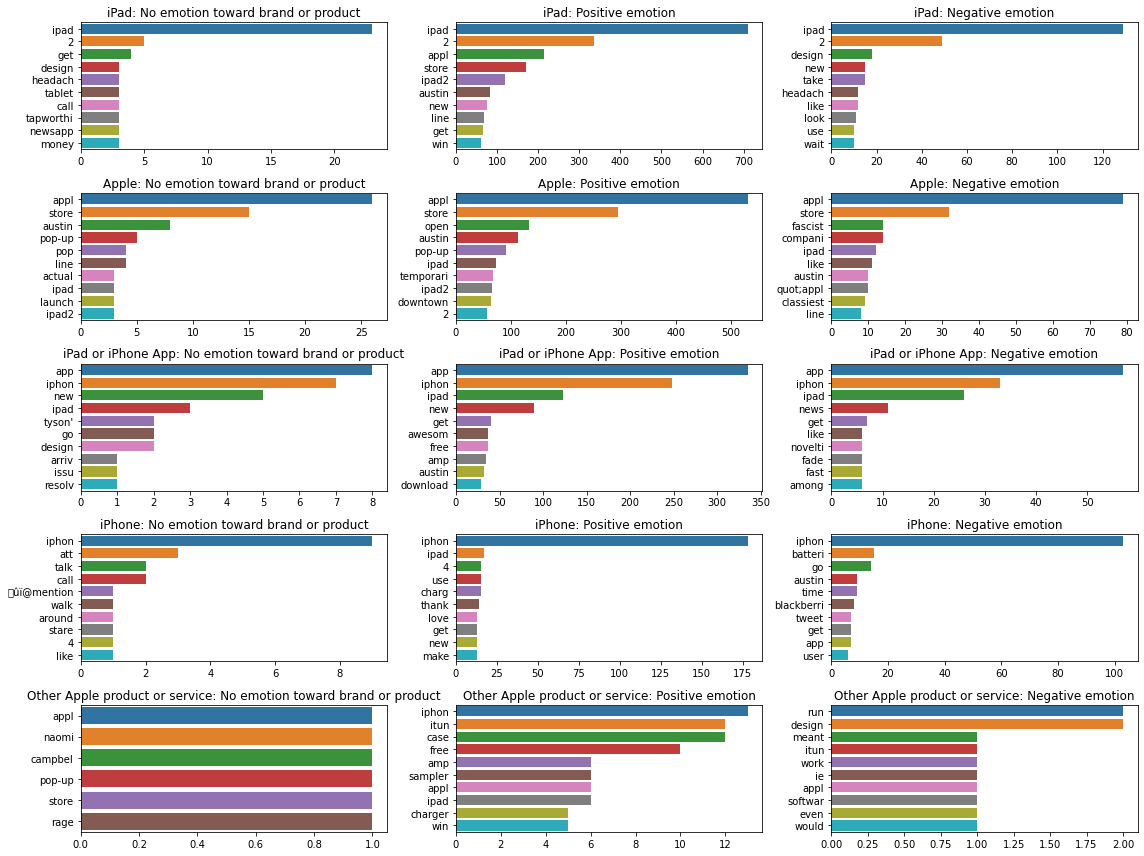

In [51]:
fig, ax = plt.subplots(ncols=3, nrows=5, figsize=(16, 12))

for i, object_of_sentiment in enumerate(
    ['iPad', 'Apple', 'iPad or iPhone App', 'iPhone', 'Other Apple product or service']
):
    for j, sentiment in enumerate(data.sentiment.value_counts().index):
        # get relevant records
        relevant_index = (data.sentiment==sentiment) & (data.object_of_sentiment==object_of_sentiment)
        relevant_tweets = data.loc[relevant_index, 'tweet_stems'].tolist()
        
        # create freq distribution & get top 10
        fdist = FreqDist(' '.join(relevant_tweets).split())
        top10 = fdist.most_common(10)
        
        # plot
        y_labels = [tup[0] for tup in top10]
        x_values = [tup[1] for tup in top10]
        sns.barplot(x=x_values, y=y_labels, ax = ax[i][j%3])
        
        ax[i][j%3].set_title(f'{object_of_sentiment}: {sentiment}')
        
fig.tight_layout();

Notice the scale; some categories don't have words that are repeated often enough to be meaningful representatives of the reason for that sentiment as a whole.

Taking extreme liberties, these are some possible interpretations of the plots above:

It does seem that people feel positively about getting free things from Apple throughout.

For some reason, blackberries are referenced in negative emotions related to the iPhone, though the battery life seems to be the top concern. There are very few people voicing these concerns, though (fewer than 20.)

Interestingly, iPad is the top word (other than iPhone) in the iPhone positive emotion category, so maybe people are happy about some synced functionality between the two (though the sample size here is still less than 25.)

In the iPad or iPhone app negative emotion category, we see that a few (less than 10) people are (perhaps) concerned about the novelty of these apps fading fast, whereas in the positive emotion category, people love getting free and/or new Apple products.

Overwhelmingly, people seem to feel positive rather than negative about the Apple store (at almost a 10:1 ratio.) People also seem to feel very positive about an Apple popup store (maybe in downtown Austin?) Funnily enough, about 12 people had something negative to say about Apple related to fascism.

Finally, people seem to love the iPad giveaway / standing in line to get a new iPad (perhaps), while a few naysayers don't love the new iPad's design.

Overall, to summarize the most significant findings (i.e. with the most support from the data), it was a great idea to do a pop-up store and have an iPad giveaway at the SXSW tech conference. Unfortunately, it is harder to determine the root source of most of the negative tweets about the Apple brand and products because only the top word shows up more than 30 times for most categories, and it is not informative of the reason behind the sentiment.

Now, let's take a look at the most common words used in tweets about Google and Android products.

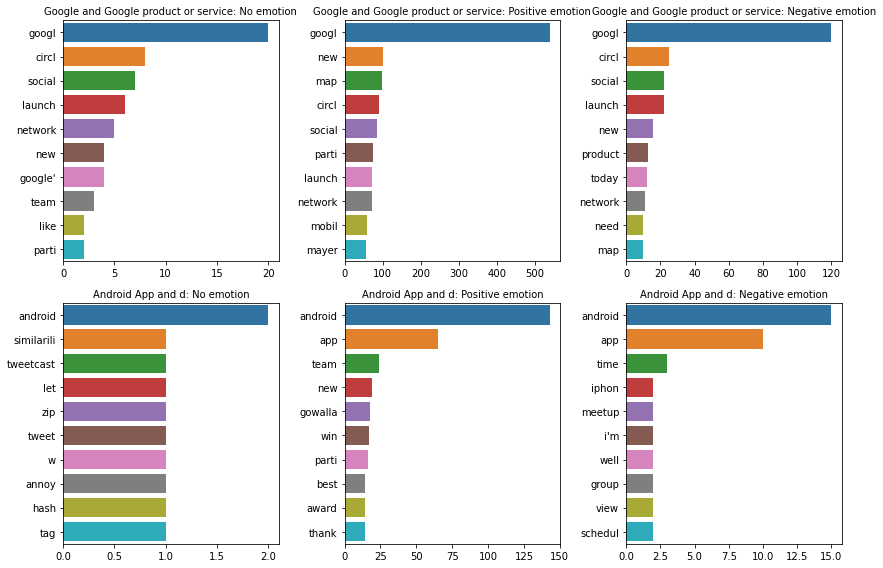

In [52]:
fig, ax = plt.subplots(ncols=3, nrows=2, figsize=(12, 8))

for i, products in enumerate([['Google', 'Other Google product or service'], ['Android App', 'Android']]):
    for j, sentiment in enumerate(data.sentiment.value_counts().index):
       # get relevant records
        relevant_index = (data.sentiment==sentiment) & (data.object_of_sentiment.isin(products))
        relevant_tweets = data.loc[relevant_index, 'tweet_stems'].tolist()
        
        # create freq distribution & get top 10
        fdist = FreqDist(' '.join(relevant_tweets).split())
        top10 = fdist.most_common(10)
        
        # plot
        y_labels = [tup[0] for tup in top10]
        x_values = [tup[1] for tup in top10]
        sns.barplot(x=x_values, y=y_labels, ax = ax[i][j%3])
        
        # title
        # no emotion toward brand or product is too long:
        sentiment_label = ' '.join(sentiment.split()[:2])
        ax[i][j%3].set_title(f'{products[0]} and {products[1][6:]}: {sentiment_label}', fontsize=10)
        
fig.tight_layout();

There's too little data (when formatted in this way) to make sense of the reasons behind the sentiments towards these products.

Before we move on, I want to sample some tweets in each sentiment category toward Apple products, to get a holistic idea of what these tweets "look like".

In [53]:
apple_products = ['iPhone', 'iPad or iPhone App', 'iPad', 'Other Apple product or service', 'Apple']
sentiments = np.unique(data.sentiment)

for product in apple_products:
    for sentiment in sentiments:
        try:
            print(f'{sentiment} toward {product}:')
            text = data.loc[
                (data.object_of_sentiment==product)&(data.sentiment==sentiment), 'tweet_text'].sample(1).values[0]
            print(text)
            print('\n')
        except:
            continue

Negative emotion toward iPhone:
Bereft wanderer. White cord, limp. Lifeless. There is no outlet for your iPhone here. #sxsw #poetry


No emotion toward brand or product toward iPhone:
ÛÏ@mention is walking around #SXSW while staring down at my iPhone 4... Just like everyone else.Û // ummmm...ditto that


Positive emotion toward iPhone:
My first #SXSW survival kit. iPhone not in the shot because I'm using it to take the picture.  {link} I might be ready.


Negative emotion toward iPad or iPhone App:
Barry Diller says iPad-only magazines like The Daily don't make sense, {link} #sxsw


No emotion toward brand or product toward iPad or iPhone App:
Follow our #SXSW coverage at {link} on mobile at {link} or with our iPhone app http://bit.ly/guardianapp


Positive emotion toward iPad or iPhone App:
It's called HOT SPOTS  -- Mobile Heatmap iPhone App (leveraging 4sq) for #SXSW Helps You Find Hot, or Quiet, Places


Negative emotion toward iPad:
#sxsw   Tried 2 days with iPAD, w/o MacBook Pr

How many tweets are concerning Apple?

In [54]:
data.loc[data.object_of_sentiment.isin(apple_products)].shape

(2402, 4)

In [55]:
2402 / len(data)

0.268770280854873

Roughly 27% of our data concerns Apple products.

## Modeling

The goal is to train a maching learning algorithm on a preprocessed version of the tweets in each category to predict the sentiment expressed in the tweet (as "positive", "negative", or "neutral".

If the model is reasonably successful, Apple could monitor sentiment toward the brand and its products via automated API calls to Twitter and application of the model to track the ratio of positive to negative to neutral tweets (and overall attention versus that of competitors) in close to real-time.

### Preprocessing

In [56]:
data.isna().sum()

tweet_text                1
object_of_sentiment    5655
sentiment                 0
tweet_stems               1
dtype: int64

In [57]:
# drop tweet that is missing tweet_text
data.dropna(subset='tweet_text', inplace=True)
print(f'We now have {data.shape[0]} records.')

We now have 8936 records.


### Train Test Split and Label Encode Target

In [58]:
# separate features and target
X = data['tweet_text']
y = data['sentiment']

# label encode the target
le = LabelEncoder()
y_encoded = pd.Series(le.fit_transform(y), index=y.index)

# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=seed)

# train val split
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=seed)

# check shapes
print(X_train.shape)
print(y_train.shape)
print('\n')
print(X_val.shape)
print(y_val.shape)
print('\n')
print(X_test.shape)
print(y_test.shape)

(5718,)
(5718,)


(1430,)
(1430,)


(1788,)
(1788,)


Check the proportions of each class in the training data.

In [59]:
y_train.value_counts(normalize=True)

1    0.602134
2    0.335607
0    0.062260
Name: proportion, dtype: float64

In [60]:
dict(zip([0, 1, 2], le.classes_))

{0: 'Negative emotion',
 1: 'No emotion toward brand or product',
 2: 'Positive emotion'}

We may have some difficulty capturing the negative class due to its tiny minority! We may even have some difficulty capturing the positive class, also; the neutral class is so big.

### More Preprocessing

I am going to try three different methods of preprocessing the tweet text to pass in to the model. The tweets need to be "clean" (lower cased, with punctuation removed and, ideally, some form of tokenization applied) before these methods can be applied, so we are going to do that preprocessing work first. We will also remove some common English stop words.

The vectorization / embedding techniques to then be applied are:
- count or term frequency inverse document frequency vectorization (using Scikit Learn's implementations; we will try both)
- using pretrained GloVe embeddings and a mean word embedding for each tweet
- training a Word2Vec model on our corpus to obtain embeddings (using gensim) and using a mean word embedding for each tweet

A fourth and final possible technique to be applied is stacking a combination of these embeddings/vectorizations to pass into the model, along with any other potentially helpful features (e.g. TextBlob's sentiment analysis polarity results for the tweet.)

#### General Clean Up

The following "clean_up" function separates a tweet into lowercased words with punctuation removed, and removes any words from the list which are included in a "stopwords" list. The stopwords list contains common English words which are not particularly semantically meaningful and a handful of "twitter-specific" stopwords like 'mention', 'link' and 'rt'.

Finally, the function rejoins all "cleaned up" words into a string.

In [61]:
# clean up (remove punctuation & change to lower case) tweets & remove english stopwords
import string
from nltk.corpus import stopwords

twitter_stopwords = ['sxsw', 'mention', 'link', 'rt']

stopwords_list = stopwords.words('english') + twitter_stopwords

def clean_up(tweet):
    return ' '.join([word.strip(string.punctuation).lower() for word in tweet.split() if
                     word.strip(string.punctuation).lower() not in stopwords_list])

In [62]:
X_train.apply(clean_up).head()

5390    android developers friends let's hang 12:30p s...
5237    ipad design tip looks like physical object ppl...
7148                                      apple store atx
7206        life would much better ipad brainwashed lines
5416    apple autocorrect weird ogilvy autocorrects id...
Name: tweet_text, dtype: object

#### Tokenization

We can employ stemming or lemmatization to obtain tokens for vectorization.

Stemming is very simple with nltk's Porter Stemmer:

In [63]:
# stemming
from nltk.stem import PorterStemmer

def get_stems(tweet):
    '''Takes in a string of words and outputs a string of stemmed tokens.'''
    stemmer = PorterStemmer()
    return ' '.join([stemmer.stem(word) for word in tweet.split()])

# test
get_stems("hi i'm rob and i'm going swimming tomorrow yayyy")

"hi i'm rob and i'm go swim tomorrow yayyy"

Lemmatization looks more complicated, but this is only because the lemmatizer from WordNet works best if part-of-speech tags are passed to it along with the word itself. Most of the code below generates a wordnet version of a part of speech tag for a word and passes it in to the lemmatizer along with the word itself.

In [65]:
# lemmatization

# imports
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
import nltk

# helper function to get wordnet pos_tags from nltk pos_tags
def get_wordnet_pos(tag):
    '''Convert POS tags generated by nltk.pos_tag to wordnet tags, for use with word net
    lemmatizer provided in the nltk.stem.wordnet package.'''
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN
    
# define function to apply lemmatizer to wordnet-tagged words to get lemmas
def get_lemmas(tweet):
    '''Takes in a string (tweet) and returns string of lemmatized tokens.'''
    # instantiate word net lemmatizer
    lemmatizer = WordNetLemmatizer()
    
    nltk_pos_tags = nltk.pos_tag(tweet.split()) # list of (word, pos_tag)
    
    wordnet_pos_tags = [(pair[0], get_wordnet_pos(pair[1])) for pair in nltk_pos_tags]
    
    return ' '.join([lemmatizer.lemmatize(*tagged_word) for tagged_word in wordnet_pos_tags])

# test
get_lemmas("hi i'm rob and i'm going swimming tomorrow yayyy")

"hi i'm rob and i'm go swim tomorrow yayyy"

Next, we'll obtain the stemmed and lemmatized tokens for the training and validation sets.

In [66]:
# get stemmed and lemmatized tokens for training & validation data
X_train_stems = X_train.apply(clean_up).apply(get_stems)
X_train_lemmas = X_train.apply(clean_up).apply(get_lemmas)

X_val_stems = X_val.apply(clean_up).apply(get_stems)
X_val_lemmas = X_val.apply(clean_up).apply(get_lemmas)

In [67]:
X_train_stems.head(2)

5390    android develop friend let' hang 12:30p saturd...
5237    ipad design tip look like physic object ppl in...
Name: tweet_text, dtype: object

In [68]:
X_train_lemmas.head(2)

5390    android developer friends let's hang 12:30p sa...
5237    ipad design tip look like physical object ppl ...
Name: tweet_text, dtype: object

The classifiers I plan to test are a random forest, naive bayes and a support vector machine.

Below is a "score_model" function which I will use to store results from training each model.

In [69]:
model_eval = {'tokenization': [], 'preprocessing': [], 'classifier': [], 'score': []}

def score_model(model, X_train, y_train, X_val, y_val, token, preprocess, clf):
    global model_eval
    try:
        model.fit(X_train, y_train)
    except:
        print('Error fitting model; check training data. Is it scaled? Try fitting separately to troubleshoot.')
        return 0
    
    model_eval['tokenization'].append(token)
    model_eval['preprocessing'].append(preprocess)
    model_eval['classifier'].append(clf)
    model_eval['score'].append(model.score(X_val, y_val))
    
    return pd.DataFrame(model_eval).tail()

Before training any of the machine learning algorithms, it is necessary to further preprocess the text of the tweets in the dataset into numerical form.

I will try using count vectorization initially which simply denotes how many times that a word in the corpus vocabulary is used in a tweet. I am using the stemmed version of the preprocessed tweets for now.

In [70]:
from sklearn.feature_extraction.text import CountVectorizer

count = CountVectorizer()

final_X_train = pd.DataFrame(count.fit_transform(X_train_stems).todense(), index=X_train_stems.index,
                                                    columns=count.vocabulary_)
final_X_val = pd.DataFrame(count.transform(X_val_stems).todense(), index=X_val.index, columns=count.vocabulary_)

final_X_train.head(2)

,android,develop,friend,let,hang,12,30p,saturday,fellow,andro,...,webmail,suppose,forb,mahalo,97,woop,youkidshavefun,tdg,exclud,interface
5390,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5237,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


For random forest and naive bayes, it is not strictly necessary to scale the data. Let's go ahead and get baseline scores for these two models with count vectorization.

In [71]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB

rf = RandomForestClassifier(random_state=seed)
nb = MultinomialNB()

score_model(rf, final_X_train, y_train, final_X_val, y_val, 'stem', 'count_vectorize', 'random_forest')
score_model(nb, final_X_train, y_train, final_X_val, y_val, 'stem', 'count_vectorize', 'naive_bayes')

,tokenization,preprocessing,classifier,score
0,stem,count_vectorize,random_forest,0.675524
1,stem,count_vectorize,naive_bayes,0.682517


For a support vector machine classifier, we do need to scale the data.

In [72]:
from sklearn.preprocessing import StandardScaler

from sklearn.svm import SVC

ss = StandardScaler()

scaled_X_train = ss.fit_transform(final_X_train)
scaled_X_val = ss.transform(final_X_val)

svc = SVC(random_state=seed)

score_model(svc, scaled_X_train, y_train, scaled_X_val, y_val, 'stem', 'count_vectorize', 'support_vector')

,tokenization,preprocessing,classifier,score
0,stem,count_vectorize,random_forest,0.675524
1,stem,count_vectorize,naive_bayes,0.682517
2,stem,count_vectorize,support_vector,0.651049


With stemming and count vectorization, Random Forest is in the lead.

Now we need to tune these classifiers, then tune the preprocessing technique (count vectorization) itself.

Before we do so, let's check the model scores with the same preprocessing technique, but lemmatization instead of stemming.

In [73]:
# refit count vectorizer and standard scaler with lemmatized data

final_X_train = pd.DataFrame(count.fit_transform(X_train_lemmas).todense(), index=X_train_lemmas.index,
                                                    columns=count.vocabulary_)
final_X_val = pd.DataFrame(count.transform(X_val_lemmas).todense(), index=X_val_lemmas.index,
                           columns=count.vocabulary_)

scaled_X_train = ss.fit_transform(final_X_train)
scaled_X_val = ss.transform(final_X_val)

# score models with new training and validation data

score_model(rf, final_X_train, y_train, final_X_val, y_val, 'lemmatize', 'count_vectorize', 'random_forest')
score_model(nb, final_X_train, y_train, final_X_val, y_val, 'lemmatize', 'count_vectorize', 'naive_bayes')
score_model(svc, scaled_X_train, y_train, scaled_X_val, y_val, 'lemmatize', 'count_vectorize', 'support_vector')

,tokenization,preprocessing,classifier,score
1,stem,count_vectorize,naive_bayes,0.682517
2,stem,count_vectorize,support_vector,0.651049
3,lemmatize,count_vectorize,random_forest,0.676923
4,lemmatize,count_vectorize,naive_bayes,0.684615
5,lemmatize,count_vectorize,support_vector,0.647552


All three classifiers perform similarly or slightly worse with lemmatization rather than stemming. So we'll continue using only stemming.

In [162]:
final_X_train = pd.DataFrame(count.fit_transform(X_train_stems).todense(), index=X_train_stems.index,
                                                    columns=count.vocabulary_)
final_X_val = pd.DataFrame(count.transform(X_val_stems).todense(), index=X_val.index, columns=count.vocabulary_)

final_X_train.head(2)

,enchant,get,trustworthi,zappo,likeabl,virgin,product,appl,longest,line,...,sitter,martin,babyheadphon,friends_off,the_gam,african,conting,anybodywanttobuymeanipad2,jailbreak,fab5
5697,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8089,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Let's try tuning the best model so far (random forest) with count vectorization.

Two of the most basic features we can tune in a random forest are 1.) the number of estimators and 2.) the complexity of each estimator. The complexity of each estimator can be controlled indirectly by specifying a maximum depth for each tree, or the minimum number of samples in a leaf to justify splitting it, etc.

The default random forest has 100 estimators. Let's inspect the depth of these trees:

In [169]:
print(f'Average tree depth: {np.mean([tree.get_depth() for tree in rf.estimators_])}')
print(f'Standard deviation: {np.std([tree.get_depth() for tree in rf.estimators_])}')

Average tree depth: 305.19
Standard deviation: 40.11874748792639


It's possible that articifically limiting the complexity of each tree could improve the model's performance (reducing overfitting, if we have any.) We can also increase the number of estimators to reduce variance.

In [174]:
param_grid = [
    {'max_depth': [100, 150, 200, 250],
     'n_estimators': [200, 300],
     'random_state': [seed]}
]

# only do three fold cross validation & use all processors, to speed up the search
grid_search = GridSearchCV(rf, param_grid, scoring='accuracy', cv=3, n_jobs=-1)

grid_search.fit(final_X_train, y_train)

print(f'The best model found has an accuracy score of: {grid_search.best_score_}.')
print(f'This model has the following parameters:')
print(f'Depth: {grid_search.best_estimator_.max_depth}')
print(f'Number of estimators: {grid_search.best_estimator_.n_estimators}')

The best model found has an accuracy score of: 0.6702223523246859.
This model has the following parameters:
Depth: 250
Number of estimators: 200


Interestingly, the best model has the greatest max depth possible given our parameter grid (indicating that, we potentially have quite a complicated function to learn, and allowing each tree to fit to that pattern more fully is the best route to take.) The number of estimators is 200 which surprises me. I want to try varying the number of estimators without a limitation on the maximum depth of each tree to see the effect of this parameter without other changes.

In [177]:
forest_sizes = [50, 100, 150, 200, 300]
train_scores = []
val_scores = []

for size in forest_sizes:
    rf = RandomForestClassifier(n_estimators=size, random_state=seed)
    rf.fit(final_X_train, y_train)
    
    train_scores.append(rf.score(final_X_train, y_train))
    val_scores.append(rf.score(final_X_val, y_val))

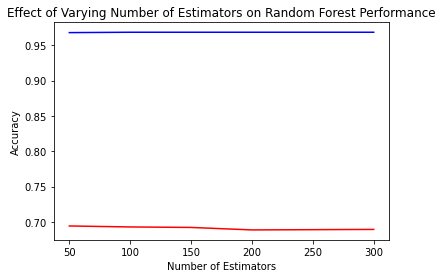

In [180]:
fig, ax = plt.subplots()

ax.set_title('Effect of Varying Number of Estimators on Random Forest Performance')
plt.plot(forest_sizes, train_scores, label='train accuracy', c='blue')
plt.plot(forest_sizes, val_scores, label='val accuracy', c='red')
ax.set_ylabel('Accuracy')
ax.set_xlabel('Number of Estimators')
ax.legend();

Interestingly, increasing the number of estimators to 300 *decreases* the validation accuracy ever so slightly, while the training accuracy remains high.

Now we can also see that the model is clearly overfit. We need to reduce variance at the inevitable expense of increasing bias.

Let's try limiting the depth of our estimators again, this time keeping track of the effect on the model's performance on both the training and validation data.

In [182]:
depth_limits = [10, 100, 200, 300, 400]
train_scores = []
val_scores = []

for limit in depth_limits:
    rf = RandomForestClassifier(max_depth=limit, random_state=seed)
    rf.fit(final_X_train, y_train)
    
    train_scores.append(rf.score(final_X_train, y_train))
    val_scores.append(rf.score(final_X_val, y_val))

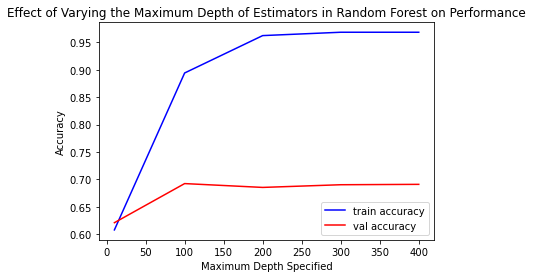

In [184]:
fig, ax = plt.subplots()

ax.set_title('Effect of Varying the Maximum Depth of Estimators in Random Forest on Performance')
plt.plot(depth_limits, train_scores, label='train accuracy', c='blue')
plt.plot(depth_limits, val_scores, label='val accuracy', c='red')
ax.set_ylabel('Accuracy')
ax.set_xlabel('Maximum Depth Specified')
ax.legend();

Increasing the maximum depth from 10 to 100 increases the model's performance on the validation set from the low 60%s to the high 60%s. After that point, validation accuracy is pretty flat, though training accuracy experiences another increase from 100 estimators to 200 estimators.

Let's try one last experiment with max depth, zooming in on the range from 10 to 200 estimators.

In [185]:
depth_limits = [25, 50, 75, 100, 125, 150, 175]
train_scores = []
val_scores = []

for limit in depth_limits:
    rf = RandomForestClassifier(max_depth=limit, random_state=seed)
    rf.fit(final_X_train, y_train)
    
    train_scores.append(rf.score(final_X_train, y_train))
    val_scores.append(rf.score(final_X_val, y_val))

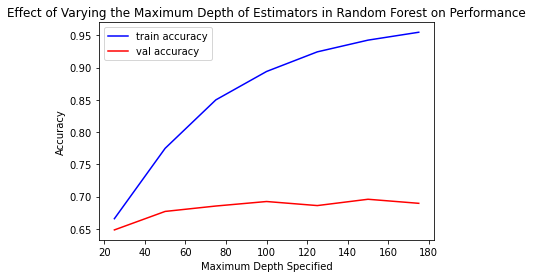

In [186]:
fig, ax = plt.subplots()

ax.set_title('Effect of Varying the Maximum Depth of Estimators in Random Forest on Performance')
plt.plot(depth_limits, train_scores, label='train accuracy', c='blue')
plt.plot(depth_limits, val_scores, label='val accuracy', c='red')
ax.set_ylabel('Accuracy')
ax.set_xlabel('Maximum Depth Specified')
ax.legend();

In [189]:
print(f'The forest with the best validation score has a max depth of: {depth_limits[np.argmax(val_scores)]}.')
print(f'The validation accuracy score for this forest is: {np.max(val_scores)}.')

The forest with the best validation score has a max depth of: 150.
The validation accuracy score for this forest is: 0.6958041958041958.


Increasing the maximum depth increases the validation score up until a maximum depth of 150. The accuracy score is not drastically higher than that of the baseline random forest, but this may be the best we can do in terms of varying the maximum depth of the random forest.

Let's quickly check the effects of increasing the number of estimators with this maximum depth. Then we can move on to injecting randomness into the model-training process.

In [190]:
forest_sizes = [50, 100, 150, 200, 300]
train_scores = []
val_scores = []

for size in forest_sizes:
    rf = RandomForestClassifier(n_estimators=size, max_depth=150, random_state=seed)
    rf.fit(final_X_train, y_train)
    
    train_scores.append(rf.score(final_X_train, y_train))
    val_scores.append(rf.score(final_X_val, y_val))

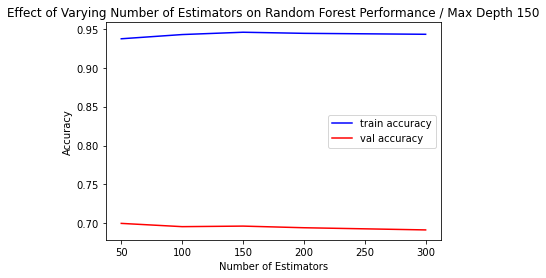

In [191]:
fig, ax = plt.subplots()

ax.set_title('Effect of Varying Number of Estimators on Random Forest Performance / Max Depth 150')
plt.plot(forest_sizes, train_scores, label='train accuracy', c='blue')
plt.plot(forest_sizes, val_scores, label='val accuracy', c='red')
ax.set_ylabel('Accuracy')
ax.set_xlabel('Number of Estimators')
ax.legend();

Now we can try improving performance by injecting randomness into the model-training process.

One way that we can "add randomness" is by adjusting the percentage of the dataset which is used to train each estimator in the ensemble. Currently, the model uses the entire training set to train each tree. We can adjust this to use a random sample of the dataset to train each model. Assigning a float to this value tells the model what percentage of the dataset to sample.

In [192]:
sample_size = [0.25, 0.5, 0.75, 1]
train_scores = []
val_scores = []

for size in sample_size:
    rf = RandomForestClassifier(max_samples=size, random_state=seed)
    rf.fit(final_X_train, y_train)
    
    train_scores.append(rf.score(final_X_train, y_train))
    val_scores.append(rf.score(final_X_val, y_val))

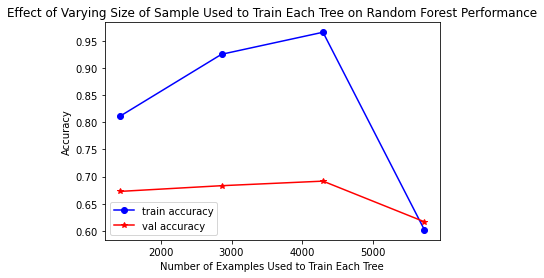

In [196]:
fig, ax = plt.subplots()

ax.set_title('Effect of Varying Size of Sample Used to Train Each Tree on Random Forest Performance')
num_samples = [percent*final_X_train.shape[0] for percent in sample_size]
plt.plot(num_samples, train_scores, label='train accuracy', c='blue', marker='o')
plt.plot(num_samples, val_scores, label='val accuracy', c='red', marker='*')
ax.set_ylabel('Accuracy')
ax.set_xlabel('Number of Examples Used to Train Each Tree')
ax.legend();

Validation and training accuracy both climb as the percentage of the dataset sampled to train each tree increases to 75%. Then both plummet when we use the entire dataset to train each tree.

Let's try a closer grid search between 75% and 100% of all samples.

In [197]:
sample_size = [0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1]
train_scores = []
val_scores = []

for size in sample_size:
    rf = RandomForestClassifier(max_samples=size, random_state=seed)
    rf.fit(final_X_train, y_train)
    
    train_scores.append(rf.score(final_X_train, y_train))
    val_scores.append(rf.score(final_X_val, y_val))

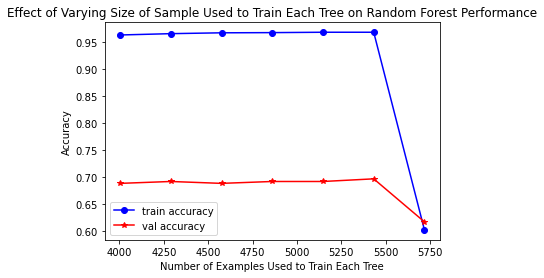

In [198]:
fig, ax = plt.subplots()

ax.set_title('Effect of Varying Size of Sample Used to Train Each Tree on Random Forest Performance')
num_samples = [percent*final_X_train.shape[0] for percent in sample_size]
plt.plot(num_samples, train_scores, label='train accuracy', c='blue', marker='o')
plt.plot(num_samples, val_scores, label='val accuracy', c='red', marker='*')
ax.set_ylabel('Accuracy')
ax.set_xlabel('Number of Examples Used to Train Each Tree')
ax.legend();

The model's performance on both the training and the validation set is pretty steady until 100%.

Let's narrow down the search for the optimal percentage of the dataset one more time.

In [199]:
sample_size = [0.95, 0.955, 0.96, 0.965, 0.97, 0.975, 0.98, 0.985, 0.99, 0.995, 1]
train_scores = []
val_scores = []

for size in sample_size:
    rf = RandomForestClassifier(max_samples=size, random_state=seed)
    rf.fit(final_X_train, y_train)
    
    train_scores.append(rf.score(final_X_train, y_train))
    val_scores.append(rf.score(final_X_val, y_val))

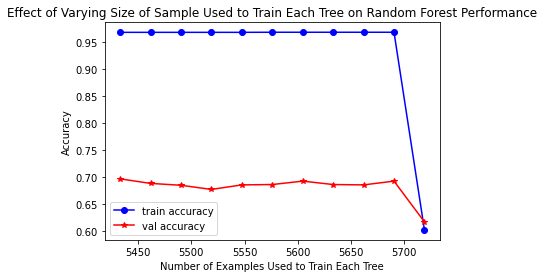

In [200]:
fig, ax = plt.subplots()

ax.set_title('Effect of Varying Size of Sample Used to Train Each Tree on Random Forest Performance')
num_samples = [percent*final_X_train.shape[0] for percent in sample_size]
plt.plot(num_samples, train_scores, label='train accuracy', c='blue', marker='o')
plt.plot(num_samples, val_scores, label='val accuracy', c='red', marker='*')
ax.set_ylabel('Accuracy')
ax.set_xlabel('Number of Examples Used to Train Each Tree')
ax.legend();

Now let's look at the combined effect of altering all three parameters.

The model with the best validation accuracy prior to adjusting max_samples had 50 estimators, each with a maximum depth of 150.

With default settings for these parameters, a model with a max_samples considered at each split equal to 75% - 95% of the dataset seems to work best. Let's try these out together.

In [201]:
sample_size = [0.75, 0.775, 0.8, 0.825, 0.85, 0.875, 0.9, 0.925, 0.95]
train_scores = []
val_scores = []

for size in sample_size:
    rf = RandomForestClassifier(max_samples=size, n_estimators=50, max_depth=150, random_state=seed)
    rf.fit(final_X_train, y_train)
    
    train_scores.append(rf.score(final_X_train, y_train))
    val_scores.append(rf.score(final_X_val, y_val))

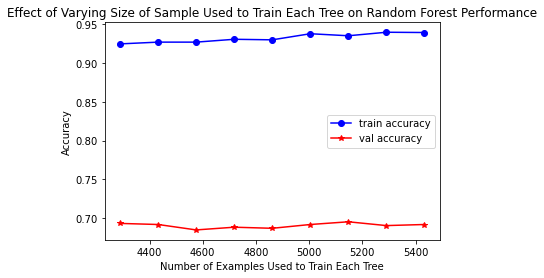

In [202]:
fig, ax = plt.subplots()

ax.set_title('Effect of Varying Size of Sample Used to Train Each Tree on Random Forest Performance')
num_samples = [percent*final_X_train.shape[0] for percent in sample_size]
plt.plot(num_samples, train_scores, label='train accuracy', c='blue', marker='o')
plt.plot(num_samples, val_scores, label='val accuracy', c='red', marker='*')
ax.set_ylabel('Accuracy')
ax.set_xlabel('Number of Examples Used to Train Each Tree')
ax.legend();

In [203]:
print(f'The best % of examples to use when training an individual tree is: {sample_size[np.argmax(val_scores)]}.')
print(f'The validation score obtained is: {np.max(val_scores)}.')

The best % of examples to use when training an individual tree is: 0.9.
The validation score obtained is: 0.6951048951048951.


Varying the sample size has very little effect.

Lastly, the default random forest considers a subset of all training set features at each split; the default size of the subset is the square root of the total number of features in the sample.

For our dataset, that means that our model considers the following number of features at each split:

In [208]:
print(f'{round(np.sqrt(final_X_train.shape[1]))} features are considered at each split.')

80 features are considered at each split.


Because our dataset consists of extremely sparse count vectors, and each feature is a single word in the entire corpus, we might obtain greater predictive power by including more features at each split (especially since the features considered are chosen randomly, not because of their importance to the model.) With that being said, reducing the number of features even more could be seen as injecting even more randomness into our model training process, so we will try both.

In [213]:
num_features = ['log2', 0.1, 0.25, 0.5, 0.9, None]
# without previously found best params
base_train_scores = []
base_val_scores = []
# with previously found best params
train_scores = []
val_scores = []

for num in num_features:
    rf_base = RandomForestClassifier(max_features=num, random_state=seed)
    rf = RandomForestClassifier(max_features=num, max_samples=0.9, n_estimators=50, max_depth=150, random_state=seed)
    
    rf_base.fit(final_X_train, y_train)
    rf.fit(final_X_train, y_train)
    
    base_train_scores.append(rf_base.score(final_X_train, y_train))
    base_val_scores.append(rf_base.score(final_X_val, y_val))
    
    train_scores.append(rf.score(final_X_train, y_train))
    val_scores.append(rf.score(final_X_val, y_val))

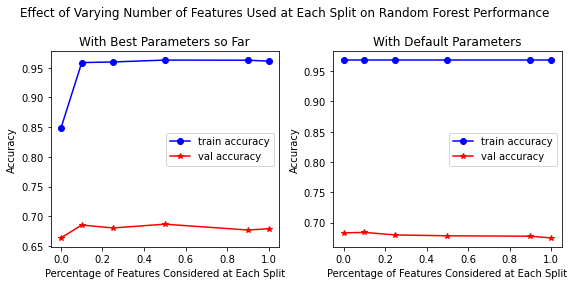

In [221]:
fig, ax = plt.subplots(ncols=2, figsize=(8, 4))

fig.suptitle('Effect of Varying Number of Features Used at Each Split on Random Forest Performance')

num_features[0] = round(np.log2(final_X_train.shape[1]) / final_X_train.shape[1])
num_features[-1] = 1 # None = 100% of features are considered

plt.sca(ax[0])
plt.plot(num_features, train_scores, label='train accuracy', c='blue', marker='o')
plt.plot(num_features, val_scores, label='val accuracy', c='red', marker='*')
ax[0].set_title('With Best Parameters so Far')
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('Percentage of Features Considered at Each Split')
ax[0].legend()

plt.sca(ax[1])
plt.plot(num_features, base_train_scores, label='train accuracy', c='blue', marker='o')
plt.plot(num_features, base_val_scores, label='val accuracy', c='red', marker='*')
ax[1].set_title('With Default Parameters')
ax[1].set_ylabel('Accuracy')
ax[1].set_xlabel('Percentage of Features Considered at Each Split')
ax[1].legend()

fig.tight_layout();

In [218]:
print(f'Best score: {np.max(val_scores)}')
print(f'Max features value: {num_features[np.argmax(val_scores)]}')

Best score: 0.6867132867132867
Max features value: 0.5


The model performs best with the default value for `max_features`.

Speaking of features, we can also try performing latent semantic analysis on our vectorized data to reduce its dimensionality and (possibly) improve model performance.

In [224]:
svd = TruncatedSVD(n_components=final_X_train.shape[1], random_state=seed)

svd.fit(final_X_train)

TruncatedSVD(n_components=6479)

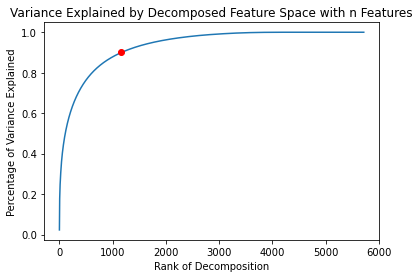

In [243]:
# find the index of the number of components at which the cumulative explained variance ratio is closest to 0.9
n_components = np.argmax(np.isclose(np.cumsum(svd.explained_variance_ratio_), 0.9, atol=0.00001))

fig, ax = plt.subplots()

ax.set_title('Variance Explained by Decomposed Feature Space with n Features')
plt.plot(list(range(1, 5720)), np.cumsum(svd.explained_variance_ratio_))
plt.plot([n_components], 0.9, marker='o', c='r')
ax.set_ylabel('Percentage of Variance Explained')
ax.set_xlabel('Rank of Decomposition');

In [246]:
print(f'Keeping the first {n_components} singular values explains ~90% of the variance in the target.')

Keeping the first 1165 singular values explains ~90% of the variance in the target.


We'll use this number of components (1165) as a starting point for training our model on components of the feature set rather than the feature set itself.

In [245]:
svd = TruncatedSVD(n_components=n_components, random_state=seed)

decomposed_X_train = svd.fit_transform(final_X_train)

Let's check the score of our best random forest classifier so far with our decomposed feature data.

In [247]:
rf = RandomForestClassifier(max_samples=0.9, n_estimators=50, max_depth=150, random_state=seed)

rf.fit(decomposed_X_train, y_train)
    
rf.score(svd.transform(final_X_val), y_val)

0.6524475524475525

Our best classifier performs worse with the decomposed data. Before we dismiss feature dimensionality completely, we'll test a range of values for the number of components kept.

In [248]:
n_components = [20, 100, 1000, 2000, 3000, 4000, 5000, 6000]
train_scores = []
val_scores = []

for num in n_components:
    svd = TruncatedSVD(n_components=num, random_state=seed)
    decomposed_X_train = svd.fit_transform(final_X_train)
    rf.fit(decomposed_X_train, y_train)
    
    train_scores.append(rf.score(decomposed_X_train, y_train))
    val_scores.append(rf.score(svd.transform(final_X_val), y_val))

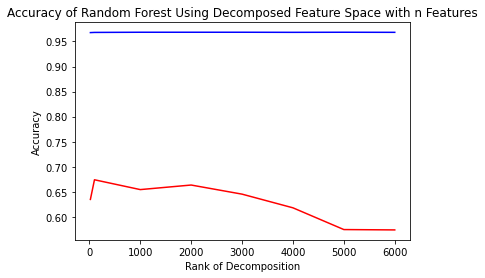

In [249]:
fig, ax = plt.subplots()

ax.set_title('Accuracy of Random Forest Using Decomposed Feature Space with n Features')
plt.plot(n_components, train_scores, label='training accuracy', c='b')
plt.plot(n_components, val_scores, label='validation accuracy', c='r')
ax.set_ylabel('Accuracy')
ax.set_xlabel('Rank of Decomposition');

Overall, applying a decomposition technique to the feature set doesn't improve the model's performance, though the 20 component feature set did perform the best. We will try one last range of values for the number of components in the decomposition before dismissing it.

In [250]:
n_components = list(range(1, 20))
train_scores = []
val_scores = []

for num in n_components:
    svd = TruncatedSVD(n_components=num, random_state=seed)
    decomposed_X_train = svd.fit_transform(final_X_train)
    rf.fit(decomposed_X_train, y_train)
    
    train_scores.append(rf.score(decomposed_X_train, y_train))
    val_scores.append(rf.score(svd.transform(final_X_val), y_val))

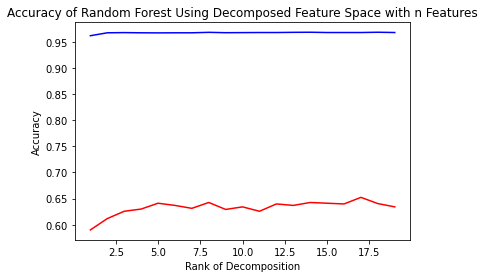

In [251]:
fig, ax = plt.subplots()

ax.set_title('Accuracy of Random Forest Using Decomposed Feature Space with n Features')
plt.plot(n_components, train_scores, label='training accuracy', c='b')
plt.plot(n_components, val_scores, label='validation accuracy', c='r')
ax.set_ylabel('Accuracy')
ax.set_xlabel('Rank of Decomposition');

Decomposing the feature set didn't allow the model to pick up on any underlying patterns in the semantics that improved performance.

Next, let's adjust the settings used by the count vectorizer when vectorizing the feature set.

One setting we can adjust to help the model pick up on meaningful differences between the tweets in each class if the minimum and maximum document frequency. These cut-off values dismiss words which are contained in more or fewer than a certain percentage of all documents. This has the double effect of ignoring words which are too obscure or too commonplace to be meaningful for classification. A common value is 0.05 / 0.95, meaning that words which are in fewer than 5% of all documents or more than 95% of all documents, will be excluded from the vocabulary.

Count vectorizer - set max df and min df, add bigrams and possibly other ngrams?

In [253]:
# use the best random forest classifier so far
rf

RandomForestClassifier(max_depth=150, max_samples=0.9, n_estimators=50,
                       random_state=3490)

In [254]:
count = CountVectorizer(min_df=0.05, max_df=0.95)

X_train_vectorized = count.fit_transform(X_train_stems)
X_val_vectorized = count.transform(X_val_stems)

rf.fit(X_train_vectorized, y_train)
rf.score(X_val_vectorized, y_val)

0.6013986013986014

Performance decreased when we limited the vectorizer's vocabulary to only those words in more than 5% of documents but fewer than 95% of documents. We will try a less dramatic cutoff, then experiment with adding some contextual information for words via bigrams and trigrams.

In [255]:
count = CountVectorizer(min_df=0.01, max_df=0.99)

X_train_vectorized = count.fit_transform(X_train_stems)
X_val_vectorized = count.transform(X_val_stems)

rf.fit(X_train_vectorized, y_train)
rf.score(X_val_vectorized, y_val)

0.6482517482517482

In [265]:
count = CountVectorizer(min_df=0.001, max_df=0.999)

X_train_vectorized = count.fit_transform(X_train_stems)
X_val_vectorized = count.transform(X_val_stems)

rf.fit(X_train_vectorized, y_train)
rf.score(X_val_vectorized, y_val)

0.693006993006993

Our model seems to perform better and better as we approach *no* minimum or maximum document frequency.

We may experiment with min and max df again after adding bigrams and / or trigrams, since eliminating less or more frequent n-grams may have a positive effect on model discernment between classes.

Let's start by including bigrams along with single words in our vectorization. This could give the model a chance to distinguish between different uses of the same word.

In [266]:
count = CountVectorizer(ngram_range=(1,2))

X_train_vectorized = count.fit_transform(X_train_stems)
X_val_vectorized = count.transform(X_val_stems)

rf.fit(X_train_vectorized, y_train)
rf.score(X_val_vectorized, y_val)

0.679020979020979

Interestingly, the performance with bigrams is slightly worse than when we included only single words. Let's try setting a boundary for minimum and maximum document frequency to exclude extremely frequently or extremely rarely occurring bigrams (and single words.)

In [267]:
count = CountVectorizer(ngram_range=(1,2), min_df=0.05, max_df=0.95)

X_train_vectorized = count.fit_transform(X_train_stems)
X_val_vectorized = count.transform(X_val_stems)

rf.fit(X_train_vectorized, y_train)
rf.score(X_val_vectorized, y_val)

0.6020979020979021

In [268]:
count = CountVectorizer(ngram_range=(1,2), min_df=0.01, max_df=0.99)

X_train_vectorized = count.fit_transform(X_train_stems)
X_val_vectorized = count.transform(X_val_stems)

rf.fit(X_train_vectorized, y_train)
rf.score(X_val_vectorized, y_val)

0.6524475524475525

Once again, the model performs increasingly better as we approach having *no* minimum or maximum document frequency. So adding bigrams to our model was not, overall, helpful for the model's performance.

Let's also try including tri-grams.

In [269]:
count = CountVectorizer(ngram_range=(1,3))

X_train_vectorized = count.fit_transform(X_train_stems)
X_val_vectorized = count.transform(X_val_stems)

rf.fit(X_train_vectorized, y_train)
rf.score(X_val_vectorized, y_val)

0.6692307692307692

And again, including tri-grams but this time, enforcing a minimum and maximum document frequency for each phrase.

In [270]:
count = CountVectorizer(ngram_range=(1,3), min_df=0.05, max_df=0.95)

X_train_vectorized = count.fit_transform(X_train_stems)
X_val_vectorized = count.transform(X_val_stems)

rf.fit(X_train_vectorized, y_train)
rf.score(X_val_vectorized, y_val)

0.6020979020979021

Out of curiosity, what if we *only* include bigrams and trigrams?

In [273]:
count = CountVectorizer(ngram_range=(2,3))

X_train_vectorized = count.fit_transform(X_train_stems)
X_val_vectorized = count.transform(X_val_stems)

rf.fit(X_train_vectorized, y_train)
rf.score(X_val_vectorized, y_val)

0.6447552447552447

Ultimately, our model performed the best with only single word count vectorization.

We can also experiment with using term frequency inverse document frequency instead of pure count vectorization. This would give the model a representation of how often a word appears in a particular tweet relative to how often it appears in all tweets in the entire corpus.

Using this new type of vectorization, we obtain the following score for our best model so far:

In [275]:
rf

RandomForestClassifier(max_depth=150, max_samples=0.9, n_estimators=50,
                       random_state=3490)

In [274]:
tfidf = TfidfVectorizer()

X_train_vectorized = tfidf.fit_transform(X_train_stems)
X_val_vectorized = tfidf.transform(X_val_stems)

rf.fit(X_train_vectorized, y_train)
rf.score(X_val_vectorized, y_val)

0.6853146853146853

With some tuning, it's possible that this method could exceed the original. Let's check the score for a default random forest classifier with our term frequency inverse document frequency vectorization method.

In [276]:
rf = RandomForestClassifier()

rf.fit(X_train_vectorized, y_train)
rf.score(X_val_vectorized, y_val)

0.6888111888111889

Rather than manually trying all of the tuning steps that we tried before, let's implement a grid search to see the effects of tuning the different parameters of a random forest classifier.

We'll start by experimenting with different values for each parameter separately. The below code will build 16$*$2 models since we are using cross validation with only 2 folds (cv=2.)

In [292]:
param_grid = [
    {'max_depth': [50, 100, 150, 200],
     'random_state': [seed]},
    {'n_estimators': [50, 100, 150, 200],
     'random_state': [seed]},
    {'max_samples': [0.05, 0.25, 0.5, 0.9],
     'random_state': [seed]},
    {'max_features': ['log2', 'sqrt', 100, 200],
     'random_state': [seed]}
]

rf = RandomForestClassifier()

grid_search = GridSearchCV(rf, param_grid, scoring='accuracy', cv=2)

grid_search.fit(X_train_vectorized, y_train)

GridSearchCV(cv=2, estimator=RandomForestClassifier(),
             param_grid=[{'max_depth': [50, 100, 150, 200],
                          'random_state': [3490]},
                         {'n_estimators': [50, 100, 150, 200],
                          'random_state': [3490]},
                         {'max_samples': [0.05, 0.25, 0.5, 0.9],
                          'random_state': [3490]},
                         {'max_features': ['log2', 'sqrt', 100, 200],
                          'random_state': [3490]}],
             scoring='accuracy')

In [295]:
pd.DataFrame(grid_search.cv_results_).loc[:, ['param_max_depth', 'param_n_estimators', 'param_max_samples',
                                              'param_max_features', 'mean_test_score']]

,param_max_depth,param_n_estimators,param_max_samples,param_max_features,mean_test_score
0,50,NaN,NaN,NaN,0.642070
1,100,NaN,NaN,NaN,0.654834
2,150,NaN,NaN,NaN,0.657981
3,200,NaN,NaN,NaN,0.659555
4,NaN,50,NaN,NaN,0.660779
5,NaN,100,NaN,NaN,0.660429
6,NaN,150,NaN,NaN,0.656757
7,NaN,200,NaN,NaN,0.658331
8,NaN,NaN,0.05,NaN,0.607099
9,NaN,NaN,0.25,NaN,0.640147


Much like with count vectorization and our random forest classifier, allowing a greater maximum depth for individual estimators, decreasing the number of total estimators to about 50, including 90% of examples at training time for each tree, and leaving max_features at its default value seems to be the best approach for allowing the model to maximize performance on the validation set.

In [291]:
pd.DataFrame(grid_search.cv_results_).loc[:, [
    'param_max_depth', 'param_n_estimators', 'mean_test_score', 'rank_test_score']]

,param_max_depth,param_n_estimators,mean_test_score,rank_test_score
0,100,200,0.664977,8
1,100,300,0.664977,7
2,150,200,0.669348,3
3,150,300,0.668299,5
4,200,200,0.668648,4
5,200,300,0.670047,2
6,250,200,0.670222,1
7,250,300,0.667425,6


Let's run through some of the parameters we can adjust for the tfidf vectorizer. These are basically the same as they were for the count vectorizer, so we'll try to iterate quickly.

In [310]:
# reset rf to best random forest classifier so far
rf = RandomForestClassifier(max_depth=150, n_estimators=50, max_samples=0.9, random_state=seed)
rf

RandomForestClassifier(max_depth=150, max_samples=0.9, n_estimators=50,
                       random_state=3490)

In [311]:
tfidf = TfidfVectorizer(min_df=0.05, max_df=0.95)

X_train_vectorized = tfidf.fit_transform(X_train_stems)
X_val_vectorized = tfidf.transform(X_val_stems)

rf.fit(X_train_vectorized, y_train)
rf.score(X_val_vectorized, y_val)

0.6188811188811189

In [312]:
tfidf = TfidfVectorizer(min_df=0.01, max_df=0.99)

X_train_vectorized = tfidf.fit_transform(X_train_stems)
X_val_vectorized = tfidf.transform(X_val_stems)

rf.fit(X_train_vectorized, y_train)
rf.score(X_val_vectorized, y_val)

0.6545454545454545

In [313]:
tfidf = TfidfVectorizer(ngram_range=(1, 2))

X_train_vectorized = tfidf.fit_transform(X_train_stems)
X_val_vectorized = tfidf.transform(X_val_stems)

rf.fit(X_train_vectorized, y_train)
rf.score(X_val_vectorized, y_val)

0.6846153846153846

In [314]:
tfidf = TfidfVectorizer(ngram_range=(1, 2), min_df=0.05, max_df=0.95)

X_train_vectorized = tfidf.fit_transform(X_train_stems)
X_val_vectorized = tfidf.transform(X_val_stems)

rf.fit(X_train_vectorized, y_train)
rf.score(X_val_vectorized, y_val)

0.6132867132867132

In [315]:
tfidf = TfidfVectorizer(ngram_range=(1, 3))

X_train_vectorized = tfidf.fit_transform(X_train_stems)
X_val_vectorized = tfidf.transform(X_val_stems)

rf.fit(X_train_vectorized, y_train)
rf.score(X_val_vectorized, y_val)

0.6888111888111889

In [316]:
tfidf = TfidfVectorizer(ngram_range=(1, 3), min_df=0.05, max_df=0.95)

X_train_vectorized = tfidf.fit_transform(X_train_stems)
X_val_vectorized = tfidf.transform(X_val_stems)

rf.fit(X_train_vectorized, y_train)
rf.score(X_val_vectorized, y_val)

0.6132867132867132

In [317]:
tfidf = TfidfVectorizer(ngram_range=(2, 3))

X_train_vectorized = tfidf.fit_transform(X_train_stems)
X_val_vectorized = tfidf.transform(X_val_stems)

rf.fit(X_train_vectorized, y_train)
rf.score(X_val_vectorized, y_val)

0.6461538461538462

A final option we could try for "tuning" the vectorizer rather than just the model is to set a hard limit on the number of words used in the vocabulary. This is similar to, but different from, applying a minimum document frequency limit, as the vectorizer drops less frequently occurring words until the target vocabulary size is reached.

In [318]:
num_features = [200, 400, 600, 800, 1000]
train_scores = []
val_scores = []

for num in num_features:
    tfidf = TfidfVectorizer(max_features=num)
    
    X_train_vectorized = tfidf.fit_transform(X_train_stems)
    X_val_vectorized = tfidf.transform(X_val_stems)

    rf.fit(X_train_vectorized, y_train)
    
    train_scores.append(rf.score(X_train_vectorized, y_train))
    val_scores.append(rf.score(X_val_vectorized, y_val))

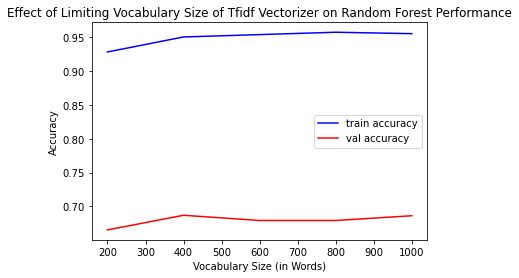

In [319]:
fig, ax = plt.subplots()

ax.set_title('Effect of Limiting Vocabulary Size of Tfidf Vectorizer on Random Forest Performance')
plt.plot(num_features, train_scores, label='train accuracy', c='b')
plt.plot(num_features, val_scores, label='val accuracy', c='r')
ax.set_xlabel('Vocabulary Size (in Words)')
ax.set_ylabel('Accuracy')
ax.legend();

In [320]:
print(f'The highest validation accuracy achieved was: {np.max(val_scores)}.')

The highest validation accuracy achieved was: 0.6867132867132867.


We have an increase in accuracy from the 200 to 400 word limit. However, the model with no restriction on the vocabulary size performed better.

Let's zoom out even more to see if there are any spots of higher performance.

In [323]:
num_features = [1000, 2000, 3000, 4000, 5000, 6000]
train_scores = []
val_scores = []

for num in num_features:
    tfidf = TfidfVectorizer(max_features=num)
    
    X_train_vectorized = tfidf.fit_transform(X_train_stems)
    X_val_vectorized = tfidf.transform(X_val_stems)

    rf.fit(X_train_vectorized, y_train)
    
    train_scores.append(rf.score(X_train_vectorized, y_train))
    val_scores.append(rf.score(X_val_vectorized, y_val))

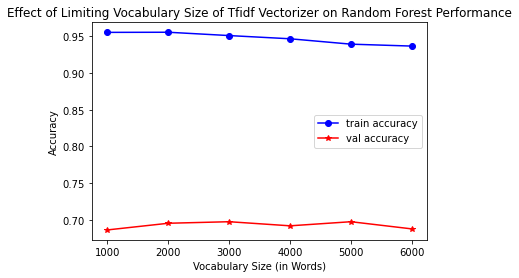

In [324]:
fig, ax = plt.subplots()

ax.set_title('Effect of Limiting Vocabulary Size of Tfidf Vectorizer on Random Forest Performance')
plt.plot(num_features, train_scores, label='train accuracy', c='b', marker='o')
plt.plot(num_features, val_scores, label='val accuracy', c='r', marker='*')
ax.set_xlabel('Vocabulary Size (in Words)')
ax.set_ylabel('Accuracy')
ax.legend();

In [326]:
print(f'The highest validation accuracy is achieved with a vocabulary size of {num_features[np.argmax(val_scores)]}.')
print(f'The validation accuracy for this model is {np.max(val_scores)}.')

The highest validation accuracy is achieved with a vocabulary size of 3000.
The validation accuracy for this model is 0.6972027972027972.


Let's zoom in between 2000 and 4000 features.

In [327]:
num_features = [2000, 2250, 2500, 2750, 3000, 3250, 3500, 3750, 4000]
train_scores = []
val_scores = []

for num in num_features:
    tfidf = TfidfVectorizer(max_features=num)
    
    X_train_vectorized = tfidf.fit_transform(X_train_stems)
    X_val_vectorized = tfidf.transform(X_val_stems)

    rf.fit(X_train_vectorized, y_train)
    
    train_scores.append(rf.score(X_train_vectorized, y_train))
    val_scores.append(rf.score(X_val_vectorized, y_val))

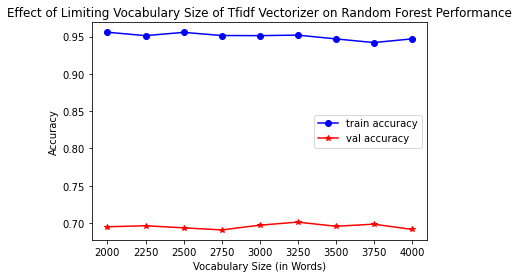

In [328]:
fig, ax = plt.subplots()

ax.set_title('Effect of Limiting Vocabulary Size of Tfidf Vectorizer on Random Forest Performance')
plt.plot(num_features, train_scores, label='train accuracy', c='b', marker='o')
plt.plot(num_features, val_scores, label='val accuracy', c='r', marker='*')
ax.set_xlabel('Vocabulary Size (in Words)')
ax.set_ylabel('Accuracy')
ax.legend();

In [329]:
print(f'The highest validation accuracy is achieved with a vocabulary size of {num_features[np.argmax(val_scores)]}.')
print(f'The validation accuracy for this model is {np.max(val_scores)}.')

The highest validation accuracy is achieved with a vocabulary size of 3250.
The validation accuracy for this model is 0.7013986013986014.


Let's zoom in on this range one more time, because this is the first time we've broken a validation accuracy of 70%.

In [330]:
num_features = [3050, 3100, 3150, 3200, 3250, 3300, 3350, 3400, 3450, 3500]
train_scores = []
val_scores = []

for num in num_features:
    tfidf = TfidfVectorizer(max_features=num)
    
    X_train_vectorized = tfidf.fit_transform(X_train_stems)
    X_val_vectorized = tfidf.transform(X_val_stems)

    rf.fit(X_train_vectorized, y_train)
    
    train_scores.append(rf.score(X_train_vectorized, y_train))
    val_scores.append(rf.score(X_val_vectorized, y_val))

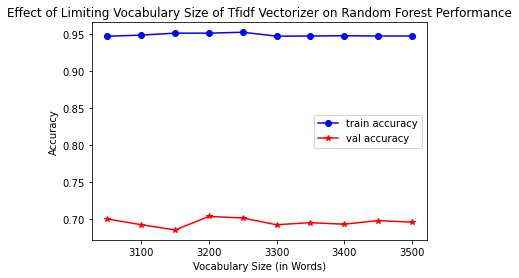

In [331]:
fig, ax = plt.subplots()

ax.set_title('Effect of Limiting Vocabulary Size of Tfidf Vectorizer on Random Forest Performance')
plt.plot(num_features, train_scores, label='train accuracy', c='b', marker='o')
plt.plot(num_features, val_scores, label='val accuracy', c='r', marker='*')
ax.set_xlabel('Vocabulary Size (in Words)')
ax.set_ylabel('Accuracy')
ax.legend();

In [332]:
print(f'The highest validation accuracy is achieved with a vocabulary size of {num_features[np.argmax(val_scores)]}.')
print(f'The validation accuracy for this model is {np.max(val_scores)}.')

The highest validation accuracy is achieved with a vocabulary size of 3200.
The validation accuracy for this model is 0.7034965034965035.


Moving forward, our best model so far uses term frequency inverse document frequency vectorization and a random forest with the following parameters.

In [333]:
tfidf

TfidfVectorizer(max_features=3500)

In [334]:
rf

RandomForestClassifier(max_depth=150, max_samples=0.9, n_estimators=50,
                       random_state=3490)

**NEXT STEPS**

- Try XGBoost (install.)
- Try under / over sampling (install.)
- Try class weights.
- Finally, threshold best model.
- Test on holdout test set!
- Display confusion matrix and discuss final model's performance.
- Be sure that notebook ends with a nice little "conclusion" summarized section.
- Add headers to show flow of notebook, any additional material in markdown to help summarize & make notebook SKIMMABLE. (diagrams from blog posts, tables in markdown showing summaries, etc.)
- Edit markdown / reread one more time to check for professional tone & beginning with the end in mind.

---

In [28]:
best_X_train = pd.DataFrame(count.fit_transform(X_train_stems).todense(), index=X_train_stems.index,
                            columns=count.vocabulary_)
best_X_val = pd.DataFrame(count.transform(X_val_stems).todense(), index=X_val_stems.index,
                          columns=count.vocabulary_)
best_X_train.head(2)

,rt,mention,android,develop,friend,let,hang,12,30p,saturday,...,webmail,suppose,forb,mahalo,97,woop,youkidshavefun,tdg,exclud,interface
5390,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5237,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [29]:
from sklearn.model_selection import GridSearchCV

param_grid = {'alpha': [1, 0.5, 10]}

grid_search = GridSearchCV(nb, param_grid, scoring='accuracy')

grid_search.fit(best_X_train, y_train)

GridSearchCV(estimator=MultinomialNB(), param_grid={'alpha': [1, 0.5, 10]},
             scoring='accuracy')

In [30]:
grid_search.best_score_

0.6631672570648949

There is very little that can be done to tune a Naive Bayes classifier. Changing the smoothing parameter didn't have a great effect.

So we'll move on to tuning the count vectorizer.

In [31]:
len(count.vocabulary_)

6512

Currently, the "baseline" count vectorizer has a vocabulary of 6512 lemmas.

One technique we can try to improve the classifier's performance is limiting the vectorizer's vocabulary to only those words which show up often enough *and* little enough to qualify as being meaningful. (Example: 'the' shows up too often to provide information, but a word which only shows up once in the entire corpus also won't help us, for example, a specific person's username.)

The below vectorizer has a "maximum document frequency" of 90% (only include a token if it appears in fewer than 90% of tweets) and a "minimum document frequency" of 5% (only include tokens which appear in more than 5% of all tweets.)

In [32]:
count = CountVectorizer(min_df=0.05, max_df=0.9)

final_X_train = pd.DataFrame(count.fit_transform(X_train_stems).todense(), index=X_train_stems.index,
                                                    columns=count.vocabulary_)
final_X_val = pd.DataFrame(count.transform(X_val_stems).todense(), index=X_val_stems.index,
                           columns=count.vocabulary_)

score_model(nb, final_X_train, y_train, final_X_val, y_val, 'stem', count, nb)

,tokenization,preprocessing,classifier,score
2,stem,count_vectorize,support_vector,0.653147
3,lemmatize,count_vectorize,random_forest,0.679021
4,lemmatize,count_vectorize,naive_bayes,0.683916
5,lemmatize,count_vectorize,support_vector,0.647552
6,stem,"CountVectorizer(max_df=0.9, min_df=0.05)",MultinomialNB(),0.612587


Our model's score is worse (by about 7%.) Let's try a more conservative maximum document frequency.

In [33]:
count = CountVectorizer(min_df=0.05, max_df=0.95)

final_X_train = pd.DataFrame(count.fit_transform(X_train_stems).todense(), index=X_train_stems.index,
                                                    columns=count.vocabulary_)
final_X_val = pd.DataFrame(count.transform(X_val_stems).todense(), index=X_val_stems.index,
                           columns=count.vocabulary_)

score_model(nb, final_X_train, y_train, final_X_val, y_val, 'stem', count, nb)

,tokenization,preprocessing,classifier,score
3,lemmatize,count_vectorize,random_forest,0.679021
4,lemmatize,count_vectorize,naive_bayes,0.683916
5,lemmatize,count_vectorize,support_vector,0.647552
6,stem,"CountVectorizer(max_df=0.9, min_df=0.05)",MultinomialNB(),0.612587
7,stem,"CountVectorizer(max_df=0.95, min_df=0.05)",MultinomialNB(),0.612587


Taking out information doesn't seem to be improving the model's performance, so let's try adding information by including bigrams in our training data.

In [34]:
count = CountVectorizer(ngram_range=(1, 2))

final_X_train = pd.DataFrame(count.fit_transform(X_train_stems).todense(), index=X_train_stems.index,
                                                    columns=count.vocabulary_)
final_X_val = pd.DataFrame(count.transform(X_val_stems).todense(), index=X_val_stems.index,
                           columns=count.vocabulary_)

score_model(nb, final_X_train, y_train, final_X_val, y_val, 'stem', count, nb)

,tokenization,preprocessing,classifier,score
4,lemmatize,count_vectorize,naive_bayes,0.683916
5,lemmatize,count_vectorize,support_vector,0.647552
6,stem,"CountVectorizer(max_df=0.9, min_df=0.05)",MultinomialNB(),0.612587
7,stem,"CountVectorizer(max_df=0.95, min_df=0.05)",MultinomialNB(),0.612587
8,stem,"CountVectorizer(ngram_range=(1, 2))",MultinomialNB(),0.690909


Adding bigrams very slightly improved the model's performance.

It's probably worth giving our other two classifiers a chance to be tuned as well before dismissing them out of hand (especially since there was so little to tune in the best model - there are a lot more knobs to turn for random forest, so perhaps it will improve significantly over the baseline.)

Going back to simply X_train_stems, let's tune our random forest classifier next.

Increasing the number of estimators should improve performance. Limiting the maximum depth of individual decision trees can help those trees not to overfit. It's possible that weighting the classes according to their ratios could improve performance as well.

In [35]:
param_grid = {'n_estimators': [100, 200, 300],
              'max_depth': [2, 10, 20, 50],
              'random_state': [seed]}

rf = RandomForestClassifier()

grid_search = GridSearchCV(rf, param_grid, scoring='accuracy')

grid_search.fit(final_X_train, y_train)

grid_search.best_score_

0.6411328610147508

Tuning the random forest failed miserably. Let's try different versions of count vectorize paired with the random forest.

In [36]:
count = CountVectorizer(min_df=0.05, max_df=0.95)

final_X_train = pd.DataFrame(count.fit_transform(X_train_stems).todense(), index=X_train_stems.index,
                             columns=count.vocabulary_)
final_X_val = pd.DataFrame(count.transform(X_val_stems).todense(), index=X_val_stems.index,
                           columns=count.vocabulary_)

score_model(rf, final_X_train, y_train, final_X_val, y_val, 'stem', count, rf)

,tokenization,preprocessing,classifier,score
5,lemmatize,count_vectorize,support_vector,0.647552
6,stem,"CountVectorizer(max_df=0.9, min_df=0.05)",MultinomialNB(),0.612587
7,stem,"CountVectorizer(max_df=0.95, min_df=0.05)",MultinomialNB(),0.612587
8,stem,"CountVectorizer(ngram_range=(1, 2))",MultinomialNB(),0.690909
9,stem,"CountVectorizer(max_df=0.95, min_df=0.05)","(DecisionTreeClassifier(max_features='sqrt', r...",0.581119


Once again, let's try adding bigrams instead of specifying document frequency limits.

In [37]:
count = CountVectorizer(ngram_range=(1, 2))

final_X_train = pd.DataFrame(count.fit_transform(X_train_stems).todense(), index=X_train_stems.index,
                             columns=count.vocabulary_)
final_X_val = pd.DataFrame(count.transform(X_val_stems).todense(), index=X_val_stems.index,
                           columns=count.vocabulary_)

score_model(rf, final_X_train, y_train, final_X_val, y_val, 'stem', count, rf)

,tokenization,preprocessing,classifier,score
6,stem,"CountVectorizer(max_df=0.9, min_df=0.05)",MultinomialNB(),0.612587
7,stem,"CountVectorizer(max_df=0.95, min_df=0.05)",MultinomialNB(),0.612587
8,stem,"CountVectorizer(ngram_range=(1, 2))",MultinomialNB(),0.690909
9,stem,"CountVectorizer(max_df=0.95, min_df=0.05)","(DecisionTreeClassifier(max_features='sqrt', r...",0.581119
10,stem,"CountVectorizer(ngram_range=(1, 2))","(DecisionTreeClassifier(max_features='sqrt', r...",0.664336


Let's tune our support vector machine, then move on to other preprocessing techniques.

In [38]:
# too long

# count = CountVectorizer()

# final_X_train = pd.DataFrame(count.fit_transform(X_train_stems).todense(), index=X_train_stems.index,
#                              columns=count.vocabulary_)
# final_X_val = pd.DataFrame(count.transform(X_val_stems).todense(), index=X_val_stems.index,
#                            columns=count.vocabulary_)

# scaled_X_train = pd.DataFrame(ss.fit_transform(final_X_train), index=final_X_train.index,
#                               columns=final_X_train.columns)
# scaled_X_val = pd.DataFrame(ss.transform(final_X_val), index=final_X_val.index,
#                             columns=final_X_val.columns)

# param_grid = [
#     {'C': [0.01, 0.1, 1],
#      'kernel': ['poly', 'rbf'],
#      'gamma': [0.001, 0.005, 0.01],
#      'class_weight': ['balanced', {0:1, 1:1, 2:1}]}
# ]

# grid_search = GridSearchCV(svc, param_grid, scoring='accuracy')

# grid_search.fit(scaled_X_train, y_train)

# grid_search.best_score_

In [39]:
# count = CountVectorizer()

final_X_train = pd.DataFrame(count.fit_transform(X_train_stems).todense(), index=X_train_stems.index,
                             columns=count.vocabulary_)
final_X_val = pd.DataFrame(count.transform(X_val_stems).todense(), index=X_val_stems.index,
                           columns=count.vocabulary_)

scaled_X_train = pd.DataFrame(ss.fit_transform(final_X_train), index=final_X_train.index,
                              columns=final_X_train.columns)
scaled_X_val = pd.DataFrame(ss.transform(final_X_val), index=final_X_val.index,
                            columns=final_X_val.columns)

svc = SVC(kernel='poly')

score_model(svc, scaled_X_train, y_train, scaled_X_val, y_val, 'stem', count, svc)

,tokenization,preprocessing,classifier,score
7,stem,"CountVectorizer(max_df=0.95, min_df=0.05)",MultinomialNB(),0.612587
8,stem,"CountVectorizer(ngram_range=(1, 2))",MultinomialNB(),0.690909
9,stem,"CountVectorizer(max_df=0.95, min_df=0.05)","(DecisionTreeClassifier(max_features='sqrt', r...",0.581119
10,stem,"CountVectorizer(ngram_range=(1, 2))","(DecisionTreeClassifier(max_features='sqrt', r...",0.664336
11,stem,"CountVectorizer(ngram_range=(1, 2))",SVC(kernel='poly'),0.634965


In [40]:
# try fitting separately

# count = CountVectorizer()

svc = SVC(kernel='poly')

final_X_train = pd.DataFrame(count.fit_transform(X_train_stems).todense(), index=X_train_stems.index,
                             columns=count.vocabulary_)
final_X_val = pd.DataFrame(count.transform(X_val_stems).todense(), index=X_val_stems.index,
                           columns=count.vocabulary_)

scaled_X_train = pd.DataFrame(ss.fit_transform(final_X_train), index=final_X_train.index,
                              columns=final_X_train.columns)
scaled_X_val = pd.DataFrame(ss.transform(final_X_val), index=final_X_val.index,
                            columns=final_X_val.columns)

svc.fit(scaled_X_train, y_train)

SVC(kernel='poly')

Examine the performance of the best model so far (model 8.)

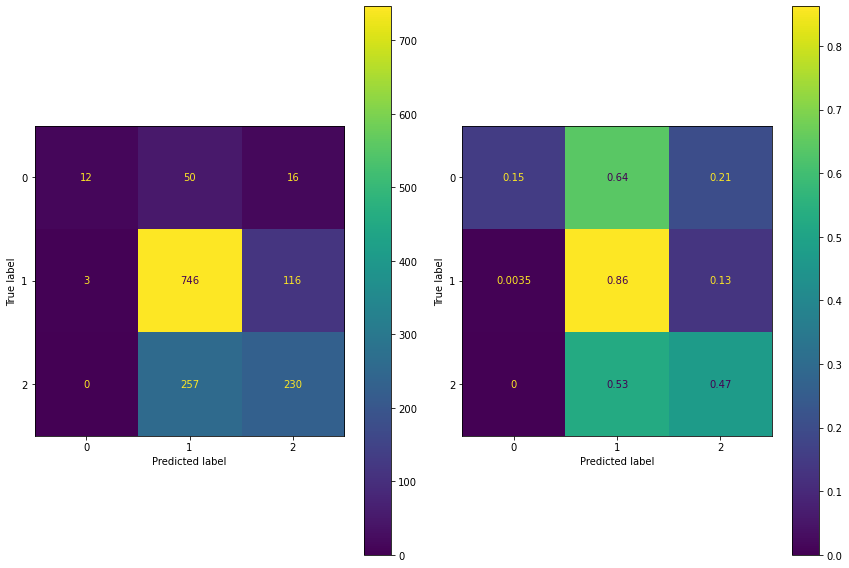

In [41]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

count = CountVectorizer(ngram_range=(1, 2))

final_X_train = pd.DataFrame(count.fit_transform(X_train_stems).todense(), index=X_train_stems.index,
                             columns=count.vocabulary_)
final_X_val = pd.DataFrame(count.transform(X_val_stems).todense(), index=X_val_stems.index,
                           columns=count.vocabulary_)

nb.fit(final_X_train, y_train)

fig, ax = plt.subplots(ncols=2, figsize=(12, 8))

ConfusionMatrixDisplay(confusion_matrix(y_val, nb.predict(final_X_val))).plot(ax=ax[0])
ConfusionMatrixDisplay(confusion_matrix(y_val, nb.predict(final_X_val), normalize='true')).plot(ax=ax[1])

fig.tight_layout();

The best model's performance corresponds loosely to class size. Let's try undersampling to get a better rate of prediction for the positive and negative classes.

In [42]:
y_train.value_counts()

1    3443
2    1919
0     356
Name: count, dtype: int64

In [43]:
# randomly undersample to make class weights equal

neutral_index = (y_train.loc[(y_train == 1)]).sample(356, random_state=seed).index
positive_index = (y_train.loc[(y_train == 2)]).sample(356, random_state=seed).index
undersampled_index = np.concatenate((neutral_index, positive_index, (y_train.loc[(y_train == 0)]).index))

y_train_undersampled = y_train.loc[undersampled_index].copy()

In [44]:
y_train_undersampled.value_counts()

1    356
2    356
0    356
Name: count, dtype: int64

In [45]:
X_train_undersampled = X_train_stems.loc[undersampled_index].copy()

final_X_train_undersampled = pd.DataFrame(count.fit_transform(X_train_undersampled).todense(),
                                          index=X_train_undersampled.index, columns=count.vocabulary_)
final_X_val_us = pd.DataFrame(count.transform(X_val).todense(), index=X_val.index, columns=count.vocabulary_)

In [46]:
nb.fit(final_X_train_undersampled, y_train_undersampled)

nb.score(final_X_val_us, y_val)

0.5671328671328671

Performance is worse. What about a different class weighting?

In [47]:
# randomly undersample to make adjust class weights

neutral_index = (y_train.loc[(y_train == 1)]).sample(356*3, random_state=seed).index
positive_index = (y_train.loc[(y_train == 2)]).sample(356*2, random_state=seed).index
undersampled_index = np.concatenate((neutral_index, positive_index, (y_train.loc[(y_train == 0)]).index))

y_train_undersampled = y_train.loc[undersampled_index].copy()
X_train_undersampled = X_train_stems.loc[undersampled_index].copy()

final_X_train_undersampled = pd.DataFrame(count.fit_transform(X_train_undersampled).todense(),
                                          index=X_train_undersampled.index, columns=count.vocabulary_)
final_X_val_us = pd.DataFrame(count.transform(X_val).todense(), index=X_val.index, columns=count.vocabulary_)

nb.fit(final_X_train_undersampled, y_train_undersampled)
nb.score(final_X_val_us, y_val)

0.6265734265734266

Another preprocessing technique we can try is that of term frequency- inverse document frequency vectorization (similar to count vectorization, but adjusted according to how often a word appears in a particular document *versus the corpus as a whole*.)

Here are the baseline results with tfidf vectorization:

In [48]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer()

final_X_train = pd.DataFrame(tfidf.fit_transform(X_train_stems).todense(), index=X_train_stems.index,
                             columns=tfidf.vocabulary_)
final_X_val = pd.DataFrame(tfidf.transform(X_val_stems).todense(), index=X_val_stems.index,
                           columns=tfidf.vocabulary_)

score_model(nb, final_X_train, y_train, final_X_val, y_val, 'stem', tfidf, nb)
score_model(rf, final_X_train, y_train, final_X_val, y_val, 'stem', tfidf, rf)

scaled_X_train = pd.DataFrame(ss.fit_transform(final_X_train), index=final_X_train.index,
                              columns=final_X_train.columns)
scaled_X_val = pd.DataFrame(ss.transform(final_X_val), index=final_X_val.index,
                            columns=final_X_val.columns)

score_model(svc, scaled_X_train, y_train, scaled_X_val, y_val, 'stem', tfidf, svc)

,tokenization,preprocessing,classifier,score
10,stem,"CountVectorizer(ngram_range=(1, 2))","(DecisionTreeClassifier(max_features='sqrt', r...",0.664336
11,stem,"CountVectorizer(ngram_range=(1, 2))",SVC(kernel='poly'),0.634965
12,stem,TfidfVectorizer(),MultinomialNB(),0.648252
13,stem,TfidfVectorizer(),"(DecisionTreeClassifier(max_features='sqrt', r...",0.684615
14,stem,TfidfVectorizer(),SVC(kernel='poly'),0.616084


Let's tune the random forest.

In [49]:
rf = RandomForestClassifier(random_state=seed, class_weight='balanced')

score_model(rf, final_X_train, y_train, final_X_val, y_val, 'stem', tfidf, rf)

,tokenization,preprocessing,classifier,score
11,stem,"CountVectorizer(ngram_range=(1, 2))",SVC(kernel='poly'),0.634965
12,stem,TfidfVectorizer(),MultinomialNB(),0.648252
13,stem,TfidfVectorizer(),"(DecisionTreeClassifier(max_features='sqrt', r...",0.684615
14,stem,TfidfVectorizer(),SVC(kernel='poly'),0.616084
15,stem,TfidfVectorizer(),"(DecisionTreeClassifier(max_features='sqrt', r...",0.665035


In [50]:
rf = RandomForestClassifier(random_state=seed, n_estimators=200)

score_model(rf, final_X_train, y_train, final_X_val, y_val, 'stem', tfidf, rf)

,tokenization,preprocessing,classifier,score
12,stem,TfidfVectorizer(),MultinomialNB(),0.648252
13,stem,TfidfVectorizer(),"(DecisionTreeClassifier(max_features='sqrt', r...",0.684615
14,stem,TfidfVectorizer(),SVC(kernel='poly'),0.616084
15,stem,TfidfVectorizer(),"(DecisionTreeClassifier(max_features='sqrt', r...",0.665035
16,stem,TfidfVectorizer(),"(DecisionTreeClassifier(max_features='sqrt', r...",0.671329


In [51]:
rf = RandomForestClassifier(random_state=seed, max_depth=2)

score_model(rf, final_X_train, y_train, final_X_val, y_val, 'stem', tfidf, rf)

,tokenization,preprocessing,classifier,score
13,stem,TfidfVectorizer(),"(DecisionTreeClassifier(max_features='sqrt', r...",0.684615
14,stem,TfidfVectorizer(),SVC(kernel='poly'),0.616084
15,stem,TfidfVectorizer(),"(DecisionTreeClassifier(max_features='sqrt', r...",0.665035
16,stem,TfidfVectorizer(),"(DecisionTreeClassifier(max_features='sqrt', r...",0.671329
17,stem,TfidfVectorizer(),"(DecisionTreeClassifier(max_depth=2, max_featu...",0.604895


In [52]:
rf = RandomForestClassifier(random_state=seed, max_depth=10)

score_model(rf, final_X_train, y_train, final_X_val, y_val, 'stem', tfidf, rf)

,tokenization,preprocessing,classifier,score
14,stem,TfidfVectorizer(),SVC(kernel='poly'),0.616084
15,stem,TfidfVectorizer(),"(DecisionTreeClassifier(max_features='sqrt', r...",0.665035
16,stem,TfidfVectorizer(),"(DecisionTreeClassifier(max_features='sqrt', r...",0.671329
17,stem,TfidfVectorizer(),"(DecisionTreeClassifier(max_depth=2, max_featu...",0.604895
18,stem,TfidfVectorizer(),"(DecisionTreeClassifier(max_depth=10, max_feat...",0.607692


In [53]:
rf = RandomForestClassifier(random_state=seed, max_depth=20)

score_model(rf, final_X_train, y_train, final_X_val, y_val, 'stem', tfidf, rf)

,tokenization,preprocessing,classifier,score
15,stem,TfidfVectorizer(),"(DecisionTreeClassifier(max_features='sqrt', r...",0.665035
16,stem,TfidfVectorizer(),"(DecisionTreeClassifier(max_features='sqrt', r...",0.671329
17,stem,TfidfVectorizer(),"(DecisionTreeClassifier(max_depth=2, max_featu...",0.604895
18,stem,TfidfVectorizer(),"(DecisionTreeClassifier(max_depth=10, max_feat...",0.607692
19,stem,TfidfVectorizer(),"(DecisionTreeClassifier(max_depth=20, max_feat...",0.626573


In [54]:
rf = RandomForestClassifier(random_state=seed, max_depth=100)

score_model(rf, final_X_train, y_train, final_X_val, y_val, 'stem', tfidf, rf)

,tokenization,preprocessing,classifier,score
16,stem,TfidfVectorizer(),"(DecisionTreeClassifier(max_features='sqrt', r...",0.671329
17,stem,TfidfVectorizer(),"(DecisionTreeClassifier(max_depth=2, max_featu...",0.604895
18,stem,TfidfVectorizer(),"(DecisionTreeClassifier(max_depth=10, max_feat...",0.607692
19,stem,TfidfVectorizer(),"(DecisionTreeClassifier(max_depth=20, max_feat...",0.626573
20,stem,TfidfVectorizer(),"(DecisionTreeClassifier(max_depth=100, max_fea...",0.679720


In [55]:
from sklearn.metrics import classification_report

rf.fit(final_X_train, y_train)

print(classification_report(y_val, rf.predict(final_X_val)))

              precision    recall  f1-score   support

           0       0.73      0.14      0.24        78
           1       0.68      0.91      0.78       865
           2       0.68      0.36      0.47       487

    accuracy                           0.68      1430
   macro avg       0.70      0.47      0.50      1430
weighted avg       0.68      0.68      0.64      1430



In [56]:
y_val.value_counts()

1    865
2    487
0     78
Name: count, dtype: int64

In [57]:
865*0.09

77.85

Our best classifier so far has a 91% recall of neutral tweets, a 14% recall of negative tweets and a 36% recall of positive tweets. Precision is much higher, with 73% precision for negative tweets, and 68% precision for both neutral and positive tweets.

This [paper](http://www.lrec-conf.org/proceedings/lrec2014/pdf/483_Paper.pdf) makes me feel a little better about the results, although the paper was written in 2014.

Another technique for preprocessing is to use word embeddings to vectorize the tweets, to avoid the sparsity seen with count vectorization and tfidf vectorization.

I will try using the pretrained GloVe embeddings which were trained on tweets.

We will use gensim to download the pretrained embeddings, but first, let's define a function to get the mean of the word vectors for all words in a tweet, given their GloVe embeddings.

Based on the average length (in words) of a tweet in this corpus, the function finds the zero-padded mean of the first 21 words in the tweet. 

In [58]:
# glove_embeddings must be stored in a variable called glove for this function to work

def get_mean_word_vector(tweet):
    '''Takes in a string (tweet) and returns the mean word vector of the tweet based on GloVe embeddings and a
    normalized tweet "length" of 21 words.'''
    # hold the GloVe embeddings for each word in the tweet
    glove_embeddings = []
    
    # iterate over each token in the tweet to add its embedding to the list
    for token in tweet.split():
        try:
            glove_embeddings.append(glove[token])
        except:
            # this token isn't in the GloVe vocab =(
            continue
    # take the padded mean of the first 21 words in the tweet
    if len(glove_embeddings) >= 21:
        padded_tweet = glove_embeddings[:21]
    elif len(glove_embeddings) >= 1:
        padded_tweet = glove_embeddings
    else:
        padded_tweet = np.array([np.zeros((50,)) for x in range(21)]) # need an array of arrays to output correct type
    return np.sum(padded_tweet, axis=0) / 21

Second, define a function which transforms a dataframe of tweet data into a dataframe in which each column represents a dimension of the mean word vector of a tweet (based on glove embeddings.)

In [59]:
def glove_embed(X_train, glove_dimensions):
    '''Get mean word vector for each tweet in df X_train based on GloVe embeddings.'''
    embedded_series = X_train.apply(get_mean_word_vector)
    
    text_features = {}
    
    for i in range(glove_dimensions):
        feature = f'feature_{i}'
        values = [embedding[i] for embedding in embedded_series.values]
        text_features[feature] = values
    
    return pd.DataFrame(text_features, index=X_train.index)

Now we can iterate over several versions of the GloVe embeddings obtained from twitter data (with different numbers of dimensions for the embeddings) and record the model score.

In [60]:
import gensim.downloader
glove_options = ['glove-twitter-25', 'glove-twitter-50', 'glove-twitter-100', 'glove-twitter-200']

from sklearn.preprocessing import MinMaxScaler

for which_glove in glove_options:
    glove = gensim.downloader.load(which_glove)
    n_dim = int(which_glove.split('-')[-1]) # number after last dash is the dimensions of the embeddings
    final_X_train = glove_embed(X_train_stems, n_dim)
    final_X_val = glove_embed(X_val_stems, n_dim)
    # using naive bayes as baseline; we need to scale between 0 and 1 to make all features positive (not an issue
    # with count or tfidf vectorization, just embeddings) so use min max scaler instead of standard scaler
    mms = MinMaxScaler()
    scaled_X_train = mms.fit_transform(final_X_train)
    scaled_X_val = mms.transform(final_X_val)
    score_model(nb, scaled_X_train, y_train, scaled_X_val, y_val, 'stem', which_glove, nb)

In [61]:
pd.DataFrame(model_eval)

,tokenization,preprocessing,classifier,score
0,stem,count_vectorize,random_forest,0.676923
1,stem,count_vectorize,naive_bayes,0.684615
2,stem,count_vectorize,support_vector,0.653147
3,lemmatize,count_vectorize,random_forest,0.679021
4,lemmatize,count_vectorize,naive_bayes,0.683916
5,lemmatize,count_vectorize,support_vector,0.647552
6,stem,"CountVectorizer(max_df=0.9, min_df=0.05)",MultinomialNB(),0.612587
7,stem,"CountVectorizer(max_df=0.95, min_df=0.05)",MultinomialNB(),0.612587
8,stem,"CountVectorizer(ngram_range=(1, 2))",MultinomialNB(),0.690909
9,stem,"CountVectorizer(max_df=0.95, min_df=0.05)","(DecisionTreeClassifier(max_features='sqrt', r...",0.581119


Let's give glove a chance with a different type of model - random forest.

In [62]:
rf = RandomForestClassifier(random_state=seed)

# last glove embedding was best (200-dimensional) so no need to re-preprocess data
score_model(rf, scaled_X_train, y_train, scaled_X_val, y_val, 'stem', which_glove, rf)

,tokenization,preprocessing,classifier,score
21,stem,glove-twitter-25,MultinomialNB(),0.604895
22,stem,glove-twitter-50,MultinomialNB(),0.604895
23,stem,glove-twitter-100,MultinomialNB(),0.604895
24,stem,glove-twitter-200,MultinomialNB(),0.605594
25,stem,glove-twitter-200,"(DecisionTreeClassifier(max_features='sqrt', r...",0.653846


This may seem like an odd approach, but I wonder if PCA could help our machine learning algorithm to learn from the data.

In [63]:
from sklearn.decomposition import PCA

pca = PCA()

pca.fit(scaled_X_train)

# how many components must be kept to explain roughly 95% of the variance in the data?
np.argmax(np.isclose(np.array([0.95]*200), np.cumsum(pca.explained_variance_ratio_), 0.005))

133

In [64]:
pca = PCA(n_components=133)

reduced_X_train = pca.fit_transform(scaled_X_train)
reduced_X_val = pca.transform(scaled_X_val)

score_model(rf, reduced_X_train, y_train, reduced_X_val, y_val, 'stem', [which_glove, pca], rf)

,tokenization,preprocessing,classifier,score
22,stem,glove-twitter-50,MultinomialNB(),0.604895
23,stem,glove-twitter-100,MultinomialNB(),0.604895
24,stem,glove-twitter-200,MultinomialNB(),0.605594
25,stem,glove-twitter-200,"(DecisionTreeClassifier(max_features='sqrt', r...",0.653846
26,stem,"[glove-twitter-200, PCA(n_components=133)]","(DecisionTreeClassifier(max_features='sqrt', r...",0.635664


Reducing the dimensionality of the glove embeddings artificially didn't have a positive effect on the model's performance.

One last technique we will try (prior to stacking) is generating our own word embeddings based on the tweets in our corpus, then creating a mean word vector for each tweet.

First, we define a helper function to get the mean word vector for each tweet (again, assuming a tweet length of 21 words.) Notice that the word2vec model we train has to be passed into the function as well as the tweet.

In [65]:
# this function takes in a word2vec model, w2v
def get_custom_mean_word_vector(tweet, w2v):
    '''Takes in a string (tweet) and returns the mean word vector of the tweet based on custom word2vec embeddings
    and a normalized tweet "length" of 21 words.'''
    embeddings = []
    for token in tweet.split():
        try:
            embeddings.append(w2v.wv[token])
        except:
            continue
            
    # check number of embeddings in tweet and pad or trim as needed
    if len(embeddings) >= 21:
        padded_tweet = embeddings[:21]
    elif len(embeddings) >= 1:
        padded_tweet = embeddings
    else:
        padded_tweet = np.array([np.zeros((w2v.vector_size,)) for x in range(21)])
        
    return np.sum(padded_tweet, axis=0) / 21

Next, we develop a function to feed the embeddings of a Word2Vec model to our helper function above to determine the mean word vector for each tweet in our training data, then produce and return a matrix in which each column corresponds to a dimension of the mean word embedding for that tweet.

In [66]:
# Word2Vec model needs to be FIT (instantiated) before calling this function; pass as 2nd arg
def custom_embed(X_train, w2v):
    '''Takes in training data and an instantiated gensim Word2Vec model; returns the matrix form of the training
    data based on a mean word vector of length 21 words and the embeddings from Word2Vec model.'''
    
    # apply helper function to X_train to get mean word vector for each tweet
    embedded_series = X_train.apply(get_custom_mean_word_vector, args=(w2v,))
    
    # convert embeddings to matrix form (each col corresponds to a dimension of the mean word embedding)
    text_features = {}
    
    for i in range(w2v.vector_size):
        feature = f'feature_{i}'
        values = [embedding[i] for embedding in embedded_series.values]
        text_features[feature] = values
    
    return pd.DataFrame(text_features, index=X_train.index)

Now, we can train a "baseline" embedding space and pass those embeddings to a classifier (in this case, Naive Bayes.)

In [67]:
from gensim.models import Word2Vec

# try default settings for training first
w2v = Word2Vec(X_train_stems.map(lambda x: x.split()))

scaled_X_train = mms.fit_transform(custom_embed(X_train_stems, w2v))
scaled_X_val = mms.transform(custom_embed(X_val_stems, w2v))

score_model(nb, scaled_X_train, y_train, scaled_X_val, y_val, 'stem', w2v, nb)

,tokenization,preprocessing,classifier,score
23,stem,glove-twitter-100,MultinomialNB(),0.604895
24,stem,glove-twitter-200,MultinomialNB(),0.605594
25,stem,glove-twitter-200,"(DecisionTreeClassifier(max_features='sqrt', r...",0.653846
26,stem,"[glove-twitter-200, PCA(n_components=133)]","(DecisionTreeClassifier(max_features='sqrt', r...",0.635664
27,stem,"Word2Vec<vocab=1641, vector_size=100, alpha=0....",MultinomialNB(),0.603497


In [68]:
# try varying the settings for training the neural net which produces word embeddings
# adjust learning rate
w2v = Word2Vec(X_train_stems.map(lambda x: x.split()), alpha=0.01)

scaled_X_train = mms.fit_transform(custom_embed(X_train_stems, w2v))
scaled_X_val = mms.transform(custom_embed(X_val_stems, w2v))

score_model(nb, scaled_X_train, y_train, scaled_X_val, y_val, 'stem', w2v, nb)

,tokenization,preprocessing,classifier,score
24,stem,glove-twitter-200,MultinomialNB(),0.605594
25,stem,glove-twitter-200,"(DecisionTreeClassifier(max_features='sqrt', r...",0.653846
26,stem,"[glove-twitter-200, PCA(n_components=133)]","(DecisionTreeClassifier(max_features='sqrt', r...",0.635664
27,stem,"Word2Vec<vocab=1641, vector_size=100, alpha=0....",MultinomialNB(),0.603497
28,stem,"Word2Vec<vocab=1641, vector_size=100, alpha=0.01>",MultinomialNB(),0.595105


In [69]:
# try varying the settings for training the neural net which produces word embeddings
# our documents are short, so try adjusting batch size & window
w2v = Word2Vec(X_train_stems.map(lambda x: x.split()), window=3, batch_words=300)

scaled_X_train = mms.fit_transform(custom_embed(X_train_stems, w2v))
scaled_X_val = mms.transform(custom_embed(X_val_stems, w2v))

score_model(nb, scaled_X_train, y_train, scaled_X_val, y_val, 'stem', w2v, nb)

,tokenization,preprocessing,classifier,score
25,stem,glove-twitter-200,"(DecisionTreeClassifier(max_features='sqrt', r...",0.653846
26,stem,"[glove-twitter-200, PCA(n_components=133)]","(DecisionTreeClassifier(max_features='sqrt', r...",0.635664
27,stem,"Word2Vec<vocab=1641, vector_size=100, alpha=0....",MultinomialNB(),0.603497
28,stem,"Word2Vec<vocab=1641, vector_size=100, alpha=0.01>",MultinomialNB(),0.595105
29,stem,"Word2Vec<vocab=1641, vector_size=100, alpha=0....",MultinomialNB(),0.602098


In [70]:
# try varying the settings for training the neural net which produces word embeddings
# adjust dimensionality of embeddings
w2v = Word2Vec(X_train_stems.map(lambda x: x.split()), vector_size=200)

scaled_X_train = mms.fit_transform(custom_embed(X_train_stems, w2v))
scaled_X_val = mms.transform(custom_embed(X_val_stems, w2v))

score_model(nb, scaled_X_train, y_train, scaled_X_val, y_val, 'stem', w2v, nb)

,tokenization,preprocessing,classifier,score
26,stem,"[glove-twitter-200, PCA(n_components=133)]","(DecisionTreeClassifier(max_features='sqrt', r...",0.635664
27,stem,"Word2Vec<vocab=1641, vector_size=100, alpha=0....",MultinomialNB(),0.603497
28,stem,"Word2Vec<vocab=1641, vector_size=100, alpha=0.01>",MultinomialNB(),0.595105
29,stem,"Word2Vec<vocab=1641, vector_size=100, alpha=0....",MultinomialNB(),0.602098
30,stem,"Word2Vec<vocab=1641, vector_size=200, alpha=0....",MultinomialNB(),0.570629


In [71]:
# try varying the settings for training the neural net which produces word embeddings
# adjust dimensionality of embeddings
w2v = Word2Vec(X_train_stems.map(lambda x: x.split()), vector_size=50)

scaled_X_train = mms.fit_transform(custom_embed(X_train_stems, w2v))
scaled_X_val = mms.transform(custom_embed(X_val_stems, w2v))

score_model(nb, scaled_X_train, y_train, scaled_X_val, y_val, 'stem', w2v, nb)

,tokenization,preprocessing,classifier,score
27,stem,"Word2Vec<vocab=1641, vector_size=100, alpha=0....",MultinomialNB(),0.603497
28,stem,"Word2Vec<vocab=1641, vector_size=100, alpha=0.01>",MultinomialNB(),0.595105
29,stem,"Word2Vec<vocab=1641, vector_size=100, alpha=0....",MultinomialNB(),0.602098
30,stem,"Word2Vec<vocab=1641, vector_size=200, alpha=0....",MultinomialNB(),0.570629
31,stem,"Word2Vec<vocab=1641, vector_size=50, alpha=0.025>",MultinomialNB(),0.604895


### Model Evaluation

First, which model has performed the best so far?

In [76]:
# get index of model with highest score
np.argmax(pd.DataFrame(model_eval).score)

8

In [78]:
# view recorded information for best model
pd.DataFrame(model_eval).loc[8,:]

tokenization                                    stem
preprocessing    CountVectorizer(ngram_range=(1, 2))
classifier                           MultinomialNB()
score                                       0.690909
Name: 8, dtype: object

Second, recreate this model, and fit to all of the training data. (We also need to recreate the preprocessing step, count vectorization.)

In [87]:
count = CountVectorizer(ngram_range=(1,2))

X_train_vectorized = pd.DataFrame(count.fit_transform(X_train_stems).todense(),
                                  index=X_train_stems.index,
                                  columns=count.vocabulary_)

In [88]:
best_model = MultinomialNB()

best_model.fit(X_train_vectorized, y_train)

MultinomialNB()

Third, apply the same preprocessing steps to the test set, without refitting the vectorizer.

In [89]:
X_test_stems = X_test.apply(clean_up).apply(get_stems)

X_test_vectorized = pd.DataFrame(count.transform(X_test_stems).todense(),
                                 index=X_test_stems.index,
                                 columns=count.vocabulary_)

Fourth, and finally, score the model on the test set.

In [90]:
best_model.score(X_test_vectorized, y_test)

0.6655480984340044

Performance is slightly worse on the test set than expected, landing at 66.55% accuracy rather than closer to 69% accuracy like the model had on the validation set.

Let's also view the confusion matrix display for this model on the test set.

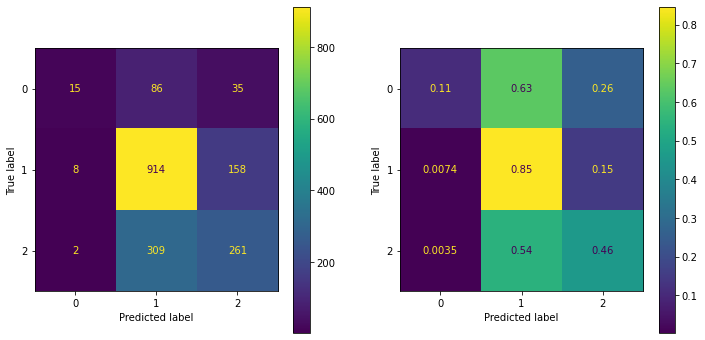

In [92]:
fig, ax = plt.subplots(ncols=2, figsize=(12, 6))

ConfusionMatrixDisplay(confusion_matrix(y_test, best_model.predict(X_test_vectorized))).plot(ax=ax[0])

ConfusionMatrixDisplay(
    confusion_matrix(y_test, best_model.predict(X_test_vectorized), normalize='true')).plot(ax=ax[1]);

In [95]:
dict(zip([0, 1, 2], le.classes_))

{0: 'Negative emotion',
 1: 'No emotion toward brand or product',
 2: 'Positive emotion'}

The model has a clear bias toward predicting the majority class ("no emotion"), mis-classifying 63% of negative tweets and 54% of positive tweets as neutral.

Regardless, the model still only classifies 85% of all neutral tweets correctly, whereas the other 15% are mostly mis-classified as positive tweets.

Practically no positive tweets are mis-classified as negative, but 26% of negative tweets are mis-classified as positive. Only 11% of negative tweets are classified correctly.

Only 46% of positive tweets are classified correctly.

Let's check the precision of the model.

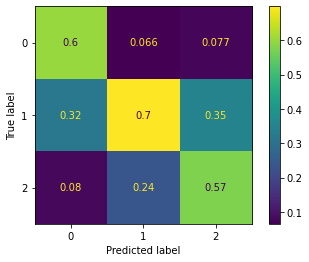

In [96]:
ConfusionMatrixDisplay(confusion_matrix(y_test, best_model.predict(X_test_vectorized), normalize='pred')).plot();

The model's performance looks better in terms of precision. 60% of the model's predictions that a tweet is negative are correct, 70% of predictions that a tweet is neutral are correct, and 57% of predictions that a tweet is positive are correct.

<u>Conclusion</u>

The model's recall of a particular class corresponds to the class-size in our sample. Collecting more data, or using a different resampling method (such as SMOTE), could help the model to rely less on this heuristic and look for genuine patterns in the tweet data which indicate sentiment.

A model which predicts the majority class every time, based on this sample, would have an accuracy of around 60%. We have beaten this accuracy score by a little over 6% with our model.

In [97]:
y_train.value_counts(normalize=True)

1    0.602134
2    0.335607
0    0.062260
Name: proportion, dtype: float64

<u>Next Steps</u>
- Analyze the most frequently occuring words and phrases in positive, negative and neutral tweets about Apple products.
- Analyze the model's decision making structure. (Because our final model is naive bayes, we are already doing so when we construct the frequency distributions for each category.) (What are the most common words in the corpus overall?)

In [105]:
train = pd.concat([X_train_stems, y_train], axis=1).rename({0: 'class'}, axis=1)

In [117]:
from nltk import FreqDist

neg_fdist = FreqDist((' '.join(train.loc[train['class'] == 0, 'tweet_text'].tolist())).split())

neut_fdist = FreqDist((' '.join(train.loc[train['class'] == 1, 'tweet_text'].tolist())).split())

pos_fdist = FreqDist((' '.join(train.loc[train['class'] == 2, 'tweet_text'].tolist())).split())

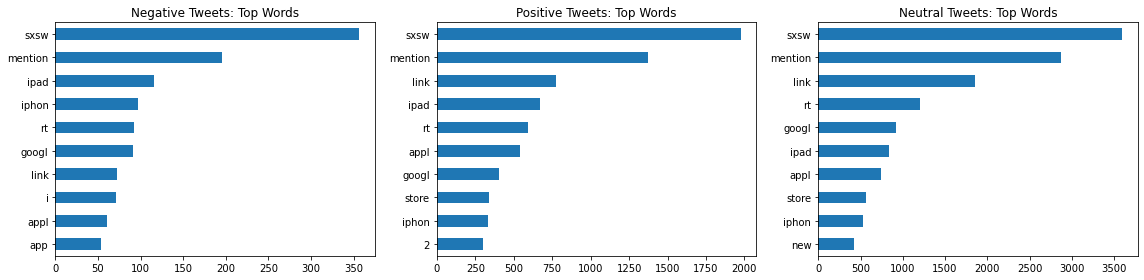

In [131]:
fig, ax = plt.subplots(ncols=3, figsize=(16, 4))

pd.Series(dict(neg_fdist.most_common(10))).plot(kind='barh', ax=ax[0])
ax[0].invert_yaxis()
ax[0].set_title('Negative Tweets: Top Words')

pd.Series(dict(pos_fdist.most_common(10))).plot(kind='barh', ax=ax[1])
ax[1].invert_yaxis()
ax[1].set_title('Positive Tweets: Top Words')

pd.Series(dict(neut_fdist.most_common(10))).plot(kind='barh', ax=ax[2])
ax[2].invert_yaxis()
ax[2].set_title('Neutral Tweets: Top Words')

fig.tight_layout();

It's a little late for this, but seeing the most common words in each category, it would seem prudent to remove some dataset specific stop words, like "sxsw" or "mention".

If we ignore words that are in over 95% of tweets, what are the top 10 words?

In [136]:
train['class'].value_counts().map(lambda x: 0.95*x)

class
1    3270.85
2    1823.05
0     338.20
Name: count, dtype: float64

In [132]:
neg_fdist

FreqDist({'sxsw': 357, 'mention': 195, 'ipad': 116, 'iphon': 97, 'rt': 92, 'googl': 91, 'link': 72, 'i': 71, 'appl': 60, 'app': 53, ...})

In [137]:
neut_fdist

FreqDist({'sxsw': 3598, 'mention': 2875, 'link': 1857, 'rt': 1205, 'googl': 921, 'ipad': 838, 'appl': 747, 'store': 566, 'iphon': 526, 'new': 421, ...})

In [138]:
pos_fdist

FreqDist({'sxsw': 1977, 'mention': 1374, 'link': 777, 'ipad': 671, 'rt': 592, 'appl': 542, 'googl': 403, 'store': 341, 'iphon': 333, '2': 302, ...})

In all three frequency distributions, we would only ignore 'sxsw'.

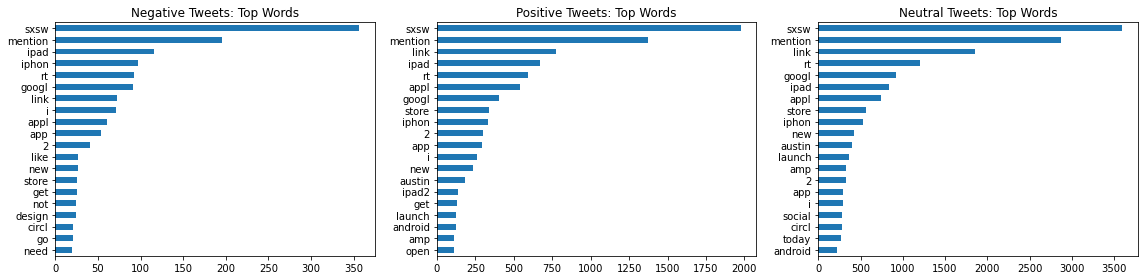

In [140]:
fig, ax = plt.subplots(ncols=3, figsize=(16, 4))

pd.Series(dict(neg_fdist.most_common(20))).plot(kind='barh', ax=ax[0])
ax[0].invert_yaxis()
ax[0].set_title('Negative Tweets: Top Words')

pd.Series(dict(pos_fdist.most_common(20))).plot(kind='barh', ax=ax[1])
ax[1].invert_yaxis()
ax[1].set_title('Positive Tweets: Top Words')

pd.Series(dict(neut_fdist.most_common(20))).plot(kind='barh', ax=ax[2])
ax[2].invert_yaxis()
ax[2].set_title('Neutral Tweets: Top Words')

fig.tight_layout();